<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

### Contents:
- [Problem Statement](#Problem-Statement)
- [Data Collection](#Data-Collection)
- [Data Cleaning & EDA](#Data-Cleaning-&-EDA)
- [Preprocessing & Modeling](#Preprocessing-&-Modeling)
- [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

This workbook only contain contents on 'Data Cleaning & EDA' and 'Preprocessing & Modeling'.

### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|word_length| int64| space, aliens| total word length for title column|
|subreddit|object|space, aliens, df|subreddit name|
|title|object|space, aliens, df|The title of the submission|
|selftext|object|space, aliens, df| markdown formatted content for a text submission|
|id |object|space, aliens, df, dfall, dfmaster|ID of the subreddit|
|score| int64| space, aliens, df, dfall, dfmaster| no of upvotes minus the no of downvotes
|upvote_ratio| float64| space, aliens, df, dfall, dfmaster| percentage of upvotes
|num_comments| int64| space, aliens, df, dfall, dfmaster| number of comments on the submission
|text_length| int64| dfall, dfmaster| total word length for text column|
|text| object| dfall, dfmaster| combination of title and selftext|
|is_aliens|int64|dfall, dfmaster|classification of subreddit|

## Data Cleaning & EDA

In [1]:
#Importing of modules
import numpy as np
import pandas as pd 
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import demoji
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Set max display of columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import nltk
from bs4 import BeautifulSoup    
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator#, STOPWORDS
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'

In [2]:
# Importing datasets
space = pd.read_csv('./data/space.csv')
aliens = pd.read_csv('./data/aliens.csv')

---
### __Analysis__

__Checking the data on subreddit space and aliens and keep those that are important__

In [3]:
space.shape

(1500, 82)

In [4]:
aliens.shape

(1500, 83)

In [5]:
space.head()

Unnamed: 0 all_awardings  allow_live_comments             author  \
0           0            []                False      Nova-Nightjar   
1           1            []                False  freedemocracy2021   
2           2            []                False    charmed_ridge96   
3           3            []                False       MistWeaver80   
4           4            []                False        daryavaseum   

   author_flair_css_class author_flair_richtext author_flair_text  \
0                     NaN                    []               NaN   
1                     NaN                    []               NaN   
2                     NaN                    []               NaN   
3                     NaN                    []               NaN   
4                     NaN                    []               NaN   

  author_flair_type author_fullname  author_is_blocked author_patreon_flair  \
0              text     t2_fux8lubh              False                False   
1              text     t2_afzozxgm              False                False   
2              text     t2_b466oaog              False                False   
3              text     t2_2vdtqcmq              False                False   
4              text     t2_64p27r3n              False                False   

  author_premium awarders  can_mod_post  contest_mode  created_utc  \
0          False       []         False         False   1640277774   
1          False       []         False         False   1640277640   
2          False       []         False         False   1640276136   
3           True       []         False         False   1640272323   
4           True       []         False         False   1640272192   

           domain                                          full_link gildings  \
0       i.redd.it  https://www.reddit.com/r/space/comments/rmzn01...       {}   
1  minddebris.com  https://www.reddit.com/r/space/comments/rmzl73...       {}   
2      self.space  https://www.reddit.com/r/space/comments/rmz1sr...       {}   
3       icrar.org  https://www.reddit.com/r/space/comments/rmxpmy...       {}   
4   instagram.com  https://www.reddit.com/r/space/comments/rmxo1b...       {}   

       id  is_created_from_ads_ui  is_crosspostable  is_meta  \
0  rmzn01                   False             False    False   
1  rmzl73                   False             False    False   
2  rmz1sr                   False              True    False   
3  rmxpmy                   False              True    False   
4  rmxo1b                   False              True    False   

   is_original_content  is_reddit_media_domain  is_robot_indexable  is_self  \
0                False                    True               False    False   
1                False                   False               False    False   
2                False                   False                True     True   
3                False                   False                True    False   
4                False                   False                True    False   

   is_video  link_flair_background_color link_flair_css_class  \
0     False                          NaN             imagegif   
1     False                          NaN                  NaN   
2     False                          NaN                black   
3     False                          NaN                  NaN   
4     False                          NaN                  NaN   

  link_flair_richtext link_flair_text link_flair_text_color link_flair_type  \
0                  []       image/gif                  dark            text   
1                  []             NaN                  dark            text   
2                  []      Discussion                  dark            text   
3                  []             NaN                  dark            text   
4                  []             NaN                  dark            text   

   locked  media_only  no_follow  num_comments  num_

In [6]:
space.columns

Index(['Unnamed: 0', 'all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_css_class', 'link_flair_richtext', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'removed_by_category', 'retrieved_on', 'score',
       'selftext', 'send_replies', 'spoiler', 'stickied', 'subredd

In [7]:
aliens.head()

Unnamed: 0 all_awardings  allow_live_comments                author  \
0           0            []                False        organicfrog328   
1           1            []                False      Jubilant-Vision2   
2           2            []                False          SpotDeusVult   
3           3            []                False  Soggy-Investigator53   
4           4            []                False             [deleted]   

  author_flair_css_class author_flair_richtext author_flair_text  \
0                    NaN                    []               NaN   
1                    NaN                    []               NaN   
2                    NaN                    []               NaN   
3                    NaN                    []               NaN   
4                    NaN                   NaN               NaN   

  author_flair_type author_fullname  author_is_blocked author_patreon_flair  \
0              text     t2_g0k75nu4              False                False   
1              text     t2_5polnc6r              False                False   
2              text     t2_d5xhe3fo              False                False   
3              text     t2_gjl4p3xr              False                False   
4               NaN             NaN              False                  NaN   

  author_premium awarders  can_mod_post  contest_mode  created_utc  \
0          False       []         False         False   1640268023   
1          False       []         False         False   1640263836   
2          False       []         False         False   1640260803   
3          False       []         False         False   1640259457   
4            NaN       []         False         False   1640256943   

             domain                                          full_link  \
0          youtu.be  https://www.reddit.com/r/aliens/comments/rmwa8...   
1       self.aliens  https://www.reddit.com/r/aliens/comments/rmv0y...   
2       self.aliens  https://www.reddit.com/r/aliens/comments/rmu72...   
3       self.aliens  https://www.reddit.com/r/aliens/comments/rmtuo...   
4  24newstodays.com  https://www.reddit.com/r/aliens/comments/rmt74...   

  gildings      id  is_created_from_ads_ui  is_crosspostable  is_meta  \
0       {}  rmwa8h                   False             False    False   
1       {}  rmv0y8                   False              True    False   
2       {}  rmu72o                   False              True    False   
3       {}  rmtuoz                   False              True    False   
4       {}  rmt74v                   False             False    False   

   is_original_content  is_reddit_media_domain  is_robot_indexable  is_self  \
0                False                   False               False    False   
1                False                   False                True     True   
2                False                   False                True     True   
3                False                   False                True     True   
4                False                   False               False    False   

   is_video link_flair_background_color  \
0     False                         NaN   
1     False                     #20692e   
2     False                         NaN   
3     False                     #20692e   
4     False                         NaN   

                                 link_flair_richtext link_flair_text_color  \
0                                                 []                  dark   
1  [{'e': 'text', 't': 'Discussion '}, {'a': ':ta...                 light   
2                                                 []                  dark   
3  [{'e': 'text', 't': 'Discussion '}, {'a': ':ta...                 light   
4                                                 []                  dark   

  link_flair_type  locked  media_only  no_follow  num_comments  \
0            text   False       False       True             0   
1        richtext   False       Fa

In [8]:
aliens.columns

Index(['Unnamed: 0', 'all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_richtext', 'link_flair_text_color', 'link_flair_type',
       'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts',
       'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'removed_by_category', 'retrieved_on', 'score', 'selftext',
       'send_replies', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_subscribers', 'subreddit_type', 'th

In [9]:
# Keep usable columns and drop columns that don't add meaning. Rearrange the columns into a more logical order.
space = space[['id', 'subreddit', 'title', 'selftext', 'score', 'upvote_ratio', 'num_comments']]
space.head()

id subreddit                                              title  \
0  rmzn01     space               Does anyone know what this ive seen?   
1  rmzl73     space                 NASA Plans a Nuclear Plant on Moon   
2  rmz1sr     space               I think black holes might be pockets   
3  rmxpmy     space  Astronomers have produced the most comprehensi...   
4  rmxo1b     space  I considered this one of the sharpest moon ima...   

                                            selftext  score  upvote_ratio  \
0                                                NaN      1           1.0   
1                                                NaN      1           1.0   
2  Pockets specifically for holding things in "fo...      1           1.0   
3                                                NaN      1           1.0   
4                                                NaN      1           1.0   

   num_comments  
0             1  
1             0  
2             0  
3             0  
4             0

In [10]:
# Keep usable columns and drop columns that don't add meaning. Rearrange the columns into a more logical order.
aliens = aliens[['id', 'subreddit', 'title', 'selftext', 'score', 'upvote_ratio', 'num_comments']]
aliens.head()

id subreddit                                              title  \
0  rmwa8h    aliens  Astronomers detected strange signal from Proxi...   
1  rmv0y8    aliens  I love alien films and stories. I came up with...   
2  rmu72o    aliens  Sorry guys, but i don't think inteligent life ...   
3  rmtuoz    aliens  Some philosophical deduction if we live in Fra...   
4  rmt74v    aliens  𝟸𝟶𝟶-ʏᴇᴀʀ-ᴏʟᴅ ᴘᴀɪɴᴛɪɴɢ ᴅᴇsᴄʀɪʙᴇs sʜᴀᴘᴇsʜɪғᴛɪɴɢ ...   

                                            selftext  score  upvote_ratio  \
0                                                NaN      1           1.0   
1  The earth gets infected by a space cloud or ne...      1           1.0   
2  Common forms of life yes, but not life like us...      1           1.0   
3    \n\n1.There is no real time.\n\n2.Time is an...      1           1.0   
4                                          [deleted]      1           1.0   

   num_comments  
0             0  
1             0  
2             0  
3             0  
4             0

In [11]:
space['word_length']=space['title'].apply(lambda x: len(x.split(' ')))
aliens['word_length']=aliens['title'].apply(lambda x: len(x.split(' ')))

In [12]:
space.describe()

score  upvote_ratio  num_comments  word_length
count   1500.000000   1500.000000   1500.000000  1500.000000
mean      22.951333      0.975527      2.220000    12.932000
std      426.728151      0.102893     27.983382     9.556931
min        0.000000      0.150000      0.000000     1.000000
25%        1.000000      1.000000      0.000000     7.000000
50%        1.000000      1.000000      0.000000    11.000000
75%        1.000000      1.000000      0.000000    16.000000
max    14202.000000      1.000000    767.000000    67.000000

In [13]:
aliens.describe()

score  upvote_ratio  num_comments  word_length
count  1500.000000   1500.000000   1500.000000  1500.000000
mean      2.005333      0.990207     12.172000    11.487333
std      19.149912      0.063888     37.424825     9.463978
min       0.000000      0.140000      0.000000     1.000000
25%       1.000000      1.000000      0.000000     5.000000
50%       1.000000      1.000000      0.000000     9.000000
75%       1.000000      1.000000      5.000000    14.000000
max     668.000000      1.000000    391.000000    57.000000

In [14]:
print(f'Average word length for space is {space["word_length"].mean():.1f}')
print(f'Average word length for aliens is {aliens["word_length"].mean():.1f}')

Average word length for space is 12.9
Average word length for aliens is 11.5


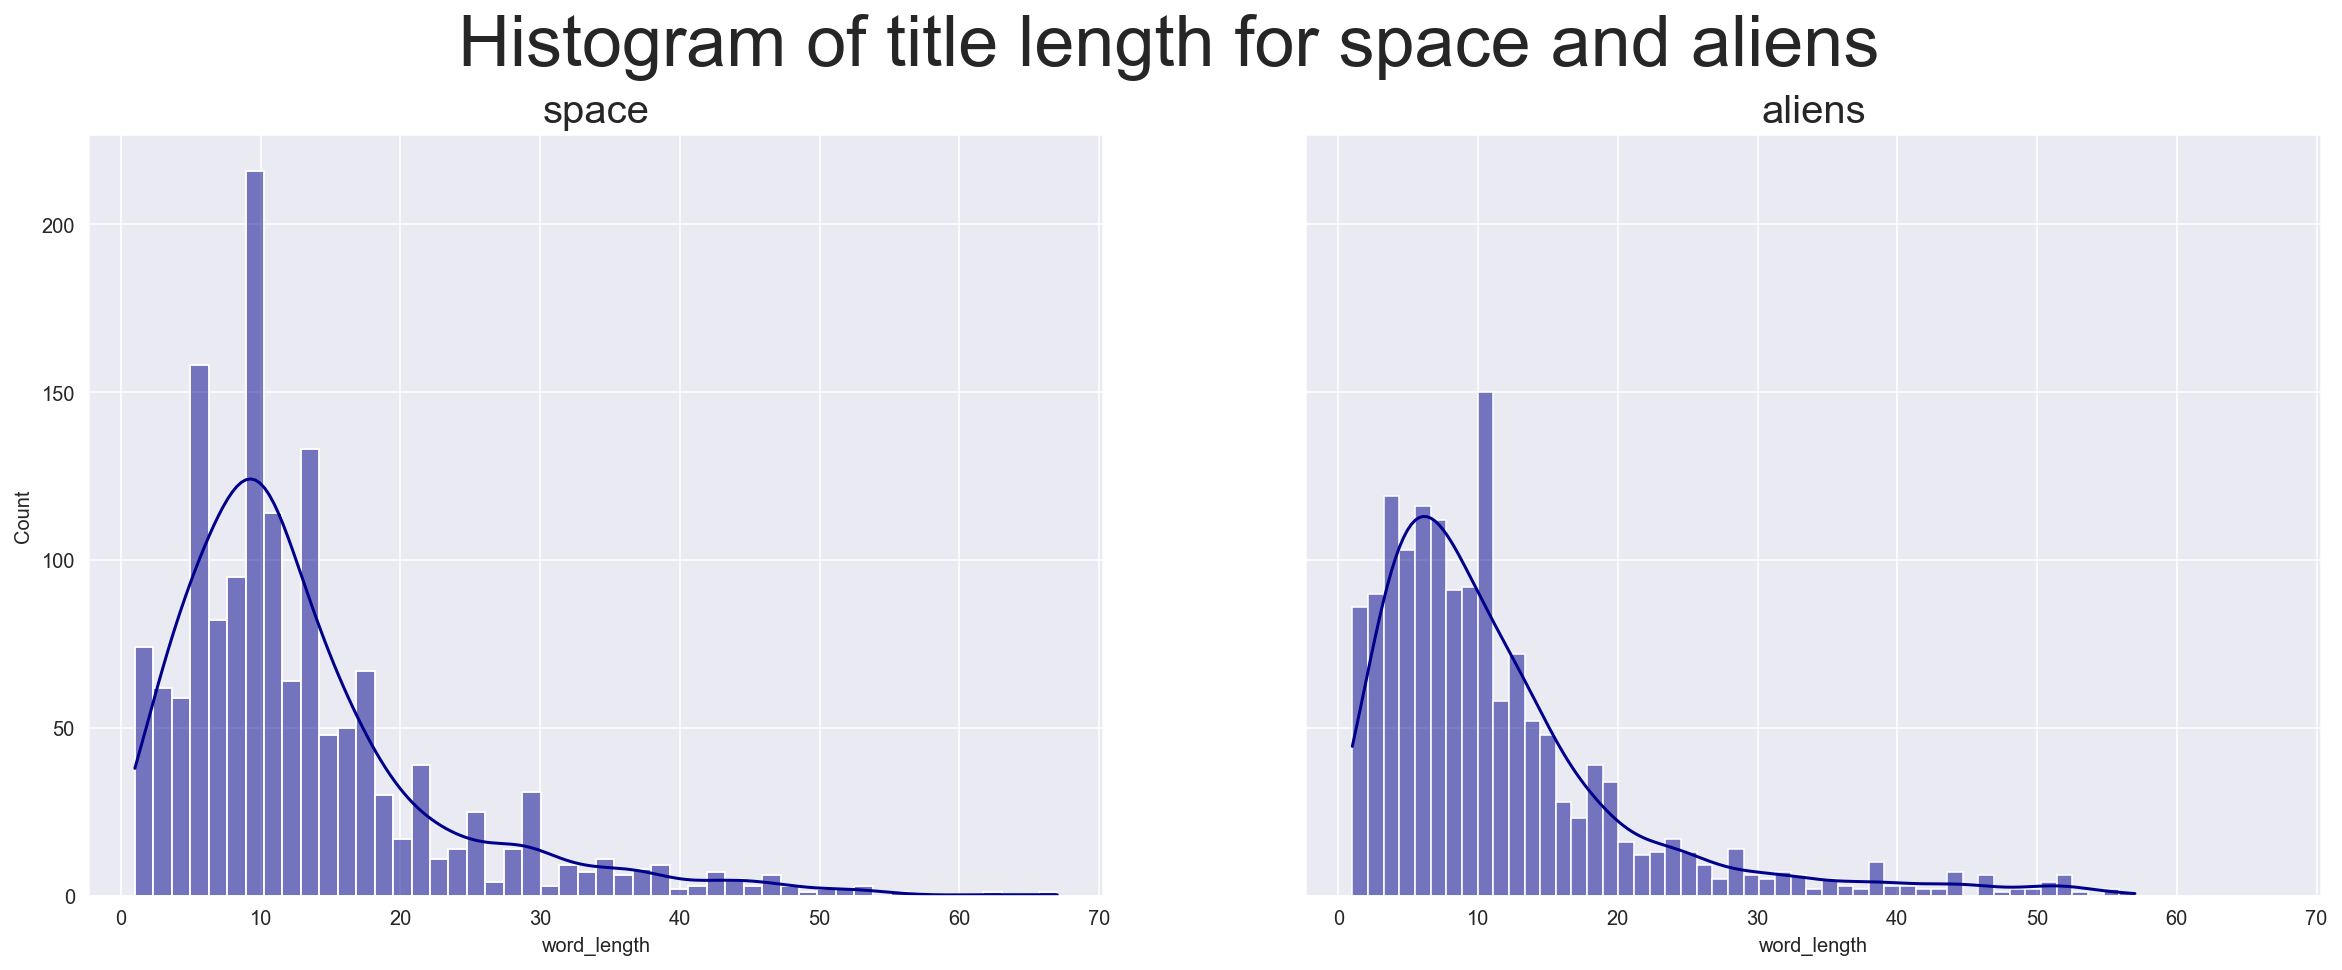

In [15]:
ncols = 2
fig,ax = plt.subplots(ncols=ncols, figsize=(ncols*10,7), sharex=True, sharey=True)

sns.histplot(data=space, x='word_length', kde=True, color= 'darkblue', bins=50, ax=ax[0])
sns.histplot(data=aliens, x='word_length', kde=True, color= 'darkblue', bins=50, ax=ax[1])

ax[0].set_title('space',fontsize=20)
ax[1].set_title('aliens',fontsize=20)

fig.suptitle('Histogram of title length for space and aliens', fontsize=36, y=1)
fig.savefig('./images/histogram_title_space_aliens.png')
plt.show();


### __Observation: Distribution of the word length__

- Are distributions examined and described? 

__The title length for both subreddits space and aliens are stewed towards the right. This is commonly found in posting forums. The average of both subreddits title length is 12-13. Also, the 75 percentile is very close to each other at 14-16. Next, we will combine both into one single dataset.__

---

In [16]:
df = pd.concat([space, aliens], ignore_index=True)
df.head()

id subreddit                                              title  \
0  rmzn01     space               Does anyone know what this ive seen?   
1  rmzl73     space                 NASA Plans a Nuclear Plant on Moon   
2  rmz1sr     space               I think black holes might be pockets   
3  rmxpmy     space  Astronomers have produced the most comprehensi...   
4  rmxo1b     space  I considered this one of the sharpest moon ima...   

                                            selftext  score  upvote_ratio  \
0                                                NaN      1           1.0   
1                                                NaN      1           1.0   
2  Pockets specifically for holding things in "fo...      1           1.0   
3                                                NaN      1           1.0   
4                                                NaN      1           1.0   

   num_comments  word_length  
0             1            7  
1             0            7  
2             0            7  
3             0           45  
4             0           22

In [17]:
df.shape

(3000, 8)

In [18]:
# Checking the datas were combined correctly 
df['subreddit'].value_counts()

space     1500
aliens    1500
Name: subreddit, dtype: int64

---
### __Observation: Missing Data__

- Are missing values imputed/handled appropriately? 

__Check whether the fields contain any missing data. Only selftext contain missing values and 60% belonged to space subreddit and 33% belonged to aliens. As selftext is text content submission, it will be retained. The missing values will be replaced with "". It will be combined to a single column for better analysis since selftext does not offered much full data. Essentially, we will retained the important selftext and combine with the title. Hence, missing data are then dealt with appropriately.__


In [19]:
df.isnull().sum()

id                 0
subreddit          0
title              0
selftext        1728
score              0
upvote_ratio       0
num_comments       0
word_length        0
dtype: int64

In [20]:
df[df['selftext'].isnull()]['subreddit'].value_counts()

space     1069
aliens     659
Name: subreddit, dtype: int64

In [21]:
df['selftext'] = df['selftext'].replace(np.nan, "")

In [22]:
df.isnull().sum()

id              0
subreddit       0
title           0
selftext        0
score           0
upvote_ratio    0
num_comments    0
word_length     0
dtype: int64

In [23]:
# After reading the files, check whether the dataframe looks as expected
df.sort_values(by='score', ascending=False).head()

id subreddit                                              title  \
1352  rb3pjh     space     NASA Returns Hubble to Full Science Operations   
1266  rbuirb     space  A Lightsail Powered By Millions of Lasers Coul...   
1291  rbopz0     space  Japanese billionaire Yusaku Maezawa lifts off ...   
1264  rbv2ai     space  NASA celebrates the life and career of 'Star T...   
1317  rbcqwg     space                               the surface of comet   

     selftext  score  upvote_ratio  num_comments  word_length  
1352           14202          0.97           501            7  
1266            7124          0.96           767           14  
1291            3679          0.94           487           12  
1264            1611          0.95            38           12  
1317            1550          0.95            81            4

In [24]:
# Save to master file
df.to_csv('./data/df.csv')

---
### __Analysis__

__Subreddit will be classified as 0 or 1 later for analysis__

In [25]:
df.dtypes

id               object
subreddit        object
title            object
selftext         object
score             int64
upvote_ratio    float64
num_comments      int64
word_length       int64
dtype: object

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3000 non-null   object 
 1   subreddit     3000 non-null   object 
 2   title         3000 non-null   object 
 3   selftext      3000 non-null   object 
 4   score         3000 non-null   int64  
 5   upvote_ratio  3000 non-null   float64
 6   num_comments  3000 non-null   int64  
 7   word_length   3000 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 187.6+ KB


---
### __Analysis__

__Check and remove for duplicate rows in title and selftext__

In [27]:
df.describe(include='all')

id subreddit                                              title  \
count     3000      3000                                               3000   
unique    3000         2                                               2879   
top     rmzn01     space   The first ever  Gaming and  NFT $Elite Fo...   
freq         1      1500                                                  8   
mean       NaN       NaN                                                NaN   
std        NaN       NaN                                                NaN   
min        NaN       NaN                                                NaN   
25%        NaN       NaN                                                NaN   
50%        NaN       NaN                                                NaN   
75%        NaN       NaN                                                NaN   
max        NaN       NaN                                                NaN   

       selftext         score  upvote_ratio  num_comments  word_length  
count      3000   3000.000000   3000.000000   3000.000000  3000.000000  
unique     1030           NaN           NaN           NaN          NaN  
top                       NaN           NaN           NaN          NaN  
freq       1728           NaN           NaN           NaN          NaN  
mean        NaN     12.478333      0.982867      7.196000    12.209667  
std         NaN    302.177293      0.085941     33.410303     9.536388  
min         NaN      0.000000      0.140000      0.000000     1.000000  
25%         NaN      1.000000      1.000000      0.000000     6.000000  
50%         NaN      1.000000      1.000000      0.000000    10.000000  
75%         NaN      1.000000      1.000000      0.000000    15.000000  
max         NaN  14202.000000      1.000000    767.000000    67.000000

In [28]:
df[df.duplicated(subset='title')]

id subreddit                                              title  \
125   rlpi4g     space   The first ever  Gaming and  NFT $Elite Fo...   
144   rlk1kt     space  Spaceport Camden in Georgia has officially rec...   
154   rlg4a8     space  Winter solstice 2021 brings the year's longest...   
162   rldzti     space                      A guide for competitive exams   
216   rl2cs8     space               郭骗从法律中学到了手段，却没学来代价 未来只能由审判席和监狱来教育违法者   
237   rkvid3     space  You can watch SpaceX launch NASA supplies to s...   
238   rkvhu7     space  God attacks and fondles me, rips my face, shoo...   
413   rjk113     space  By complete accident, I captured a massive met...   
431   rjevxp     space  God entered into my body, as a ghostly body, a...   
439   rjcs2i     space  Buy Trustpilot Reviews.100% safe non-drop 5-st...   
440   rjcq0f     space  Buy Trustpilot Reviews.100% safe non-drop 5-st...   
441   rjcpvd     space  NASA's James Webb Space Telescope officially s...   
443   rjbxrg     space  Why explore our Moon? What science can be done...   
465   rj3y8c     space  Ask Ethan: Why haven't we made "first contact"...   
471   riz3k9     space   The first ever  Gaming and  NFT $Elite Fo...   
505   rim807     space   The first ever  Gaming and  NFT $Elite Fo...   
514   rijouq     space  Interesting facts about Chamath Palihapitiya #...   
519   riimot     space  Pluto's bizarre polygons now have a science ex...   
529   rifxr4     space  Faulty cable responsible for latest James Webb...   
543   ricfox     space  Interesting facts about Chamath Palihapitiya #...   
544   ricfed     space  Interesting facts about Chamath Palihapitiya #...   
552   ri7kuw     space  Black holes and dark matter — are they one and...   
582   rhw5td     space     Space Mining Is Here, Led by This Tiny Country   
589   rhtzlf     space                                   CelesTrak launch   
595   rhrbwe     space  NASA's Perseverance rover finds organic chemic...   
607   rhpq56     space  NASA's Perseverance rover finds organic chemic...   
651   rh8q48     space                                 Telegram best plug   
679   rgyae5     space  Why the World’s Astronomers Are Very, Very Anx...   
692   rgv0hk     space  Buy Trustpilot Reviews.100% safe non-drop 5-st...   
693   rguwro     space  Buy Trustpilot Reviews.100% safe non-drop 5-st...   
707   rgn4wp     space                                               Moon   
720   rggh26     space  Five former SpaceX employees speak out about h...   
726   rgdsc9     space  NASA Enters the Solar Atmosphere for the First...   
754   rg7zxl     space                            Universe with Brian Cox   
779   rg3nfk     space  How different it is to experience a gamma ray ...   
817   rfsm2b     space  NASA to launch four Earth science missions in ...   
819   rfsdyu     space  Spelunking on the moon: New study explores lun...   
867   rfemk7     space  Hubble telescope shows the sparkling side of a...   
869   rfejs9     space  The ISS travelling over Western Australia 15 m...   
880   rfay5y     space   The first ever  Gaming and  NFT $Elite Fo...   
916   reyp65     space  How can something, so close to a Black Hole 6....   
939   retxdh     space  Student-Built Full Vehicle Liquid Rocket Stati...   
940   rettad     space  Student-Built Full Vehicle Liquid Rocket Stati...   
990   rekr5s     space                            Star formation in space   
1040  re3103     space                                       I love space   
1049  re0gep     space  If another Golden Record was sent into space, ...   
1070  rdr7xl     space  Carl Sagan Tribute Series by Milky Way Musings...   
1091  rdkc8o     space  God entered into my body, as a ghostly body, a...   
1100  rdfvnc     space                                           Solitude   
1101  rdf9me     space  “Newer, nimbler, faster:” Venus probe will sea...   
1131  rd3xe7     space  Simulated Webb Images of Quasar and Galaxy Sur...   
1140  

In [29]:
df.drop_duplicates(subset='title', inplace=True)

In [30]:
df[df.duplicated(subset='title')]

Empty DataFrame
Columns: [id, subreddit, title, selftext, score, upvote_ratio, num_comments, word_length]
Index: []

In [31]:
df[df.duplicated(subset='selftext') & (df['selftext']!='')]

id subreddit                                              title  \
58    rmcksv     space  Could dark matter be information flowing betwe...   
73    rm7hh8     space                    About Neutron Stars and Pulsars   
74    rm73ch     space  Question regarding JWST and “seeing into the p...   
123   rlqoxl     space                 How do Galaxies move through space   
183   rlba3i     space  You have learn or have heard about crypto, sto...   
191   rl97te     space                       What is SEO and How it Works   
206   rl45k8     space                                      $$$$ a day 3$   
234   rkwdo5     space  How/where to check legitimacy of 70 mm "Master...   
249   rkswx8     space  Is anyone here who had dreams of being in spac...   
253   rks214     space  Any Diverse (varying LGBTQ/POC (specifically d...   
260   rkpps7     space                                 MY YouTube channel   
286   rki0y0     space  Falcon 9 and Dragon vertical at Launch Complex...   
338   rk2601     space                     Best space videos or podcasts?   
360   rjx1tr     space  Uno, Me, Digital, 2021 description: unozerozer...   
368   rjvulm     space                                            r/space   
447   rjb3dy     space         World Top Ten Most Expensive NASA Programs   
456   rj7qwx     space                                  Free moon reading   
457   rj7pfr     space                            https://t.me/FASTPAYMEN   
548   ri9v5l     space                       My presentation on SpaceTech   
650   rh8q5p     space                                 Telegram best plug   
652   rh860n     space                                             Theory   
657   rh61vw     space  Watch Dr. Brian Keating's Podcast with Prof. B...   
686   rgwwpj     space       Does every black hole contain a singularity?   
744   rg9et7     space  Does anyone know why the Rocketwatchr seems to...   
774   rg3vwy     space                                   Please add to it   
776   rg3tce     space          SPacetech any suggestions on presentation   
782   rg27hh     space                                Amazon Web Services   
784   rg112m     space                                Universe's creation   
785   rg0u9z     space                      Bioastronautics degree help??   
818   rfsj1c     space      BTC Foundation's Official Christmas Airdrop 🦘   
841   rfm2pq     space                       50 Lost Earths - Coll Worlds   
886   rf7bou     space                        Light Curve analysis binned   
914   reyvzp     space     This image is the evolution of images of Pluto   
917   reyn0q     space         Matter that curves spacetime outwards =DE?   
946   ret493     space  All Space Questions thread for week of Decembe...   
988   rekreq     space                            Star formation in space   
1057  rdx9dl     space                             Couldn'tFindAGoodTitle   
1064  rdsxiq     space   Just thought of this, let me know what you think   
1069  rdrf49     space  Carl Sagan Tribute Series by Milky Way Musings...   
1076  rdocx1     space                         James webb space telescope   
1077  rdo9d7     space                         James Webb Space Telescope   
1078  rdo7dc     space                                               JWST   
1115  rd9o4a     space  Its weird how most people when they look at th...   
1128  rd45os     space                         Cool space animation video   
1132  rd2b77     space                                        planetarium   
1150  rcto84     space            A question that keeps me awake at night   
1172  rcmsy0     space       A Measured Defense of SpaceX &amp; Elon Musk   
1194  rcfqis     space     Gemini meteor shower 2021 peaks December 13-14   
1225  rc3m7v     space  Am I missing something? It seems like FTL trav...   
1226  rc3m0l     space  Graphic: EVERY mission to the Jupiter System (...   
1232  rc1dty     space                        how to stop a asteroid idea   
1236  

In [32]:
df['selftext'] = df['selftext'].replace('[removed]', '')
df['selftext'] = df['selftext'].replace('[deleted]', '')

In [33]:
df[df.duplicated(subset='selftext') & (df['selftext']!='')]

id subreddit                                              title  \
774   rg3vwy     space                                   Please add to it   
776   rg3tce     space          SPacetech any suggestions on presentation   
946   ret493     space  All Space Questions thread for week of Decembe...   
1655  rjvvdx    aliens  Hi community I have created a t shirt design c...   
1674  rj9ksl    aliens  I created a t shirt design that captures the m...   
2185  r99f1g    aliens  When is the ‘first-contact’ going to happen ? ...   
2899  qtj87j    aliens                   I SAW A UFO ON GOT IT ON CAMARA!   

                                               selftext  score  upvote_ratio  \
774               [Video](https://youtu.be/eu00LzOEJaY)      1           1.0   
776               [Video](https://youtu.be/eu00LzOEJaY)      1           1.0   
946   Please sort comments by 'new' to find question...      1           1.0   
1655  Hi community I created a t shirt design captur...      1           1.0   
1674  Hi community I created a t shirt design captur...      1           1.0   
2185                                              Title      1           1.0   
2899  [https://www.youtube.com/watch?v=5B7qllT2fs8](...      1           1.0   

      num_comments  word_length  
774              0            4  
776              0            5  
946              0           10  
1655             0           16  
1674             0           14  
2185             0           10  
2899             6            9

In [34]:
# Dropping duplicated rows
# Row 776, 946, 1655, 2185 and 2899will be kept as they are not duplicates
df.drop([774,1674], axis=0, inplace=True)

In [35]:
df[df.duplicated(subset='selftext') & (df['selftext']!='')]

id subreddit                                              title  \
776   rg3tce     space          SPacetech any suggestions on presentation   
946   ret493     space  All Space Questions thread for week of Decembe...   
1655  rjvvdx    aliens  Hi community I have created a t shirt design c...   
2185  r99f1g    aliens  When is the ‘first-contact’ going to happen ? ...   
2899  qtj87j    aliens                   I SAW A UFO ON GOT IT ON CAMARA!   

                                               selftext  score  upvote_ratio  \
776               [Video](https://youtu.be/eu00LzOEJaY)      1           1.0   
946   Please sort comments by 'new' to find question...      1           1.0   
1655  Hi community I created a t shirt design captur...      1           1.0   
2185                                              Title      1           1.0   
2899  [https://www.youtube.com/watch?v=5B7qllT2fs8](...      1           1.0   

      num_comments  word_length  
776              0            5  
946              0           10  
1655             0           16  
2185             0           10  
2899             6            9

In [36]:
df.describe(include='all')

id subreddit                                 title selftext  \
count     2877      2877                                  2877     2877   
unique    2877         2                                  2877     1019   
top     rmzn01    aliens  Does anyone know what this ive seen?            
freq         1      1446                                     1     1854   
mean       NaN       NaN                                   NaN      NaN   
std        NaN       NaN                                   NaN      NaN   
min        NaN       NaN                                   NaN      NaN   
25%        NaN       NaN                                   NaN      NaN   
50%        NaN       NaN                                   NaN      NaN   
75%        NaN       NaN                                   NaN      NaN   
max        NaN       NaN                                   NaN      NaN   

               score  upvote_ratio  num_comments  word_length  
count    2877.000000   2877.000000   2877.000000  2877.000000  
unique           NaN           NaN           NaN          NaN  
top              NaN           NaN           NaN          NaN  
freq             NaN           NaN           NaN          NaN  
mean       12.950991      0.982652      7.471324    12.257560  
std       308.560899      0.086523     34.073944     9.567347  
min         0.000000      0.140000      0.000000     1.000000  
25%         1.000000      1.000000      0.000000     6.000000  
50%         1.000000      1.000000      0.000000    10.000000  
75%         1.000000      1.000000      1.000000    15.000000  
max     14202.000000      1.000000    767.000000    67.000000

---
### __Observation: Summary Statistics__

Are appropriate summary statistics provided?

- All duplicates removed. Based on the above statistics, there are 2877 titles and 2877 selftext.
- The mean upvote ratio showed 0.98. It indicated that out of 10 votes, almost all 10 votes are in support. It has a low deviation of 0.0865 meaning the data are closer together and not spread out.
- For score, the min=0 and max=14202 showed that it has quite a high variance. The mean is 13 and the standard deviation is 309 showed that the data are close together and not spread out.
- Average comments is 7 per post and standard deviation is 34. It indicated a high variance.

In [37]:
# Checking the datas were combined correctly 
df['subreddit'].value_counts()

aliens    1446
space     1431
Name: subreddit, dtype: int64

---
### __Observation: Remove Outliners__


__We are combining the title and selftext into one feature. This is for the model to study the words more efficiently.__

In [38]:
# Combine title and selftext into 1 single column
df['text'] = df['title'] + ' ' + df['selftext']

In [39]:
df['text'].isna().sum()

0

In [40]:
# Create a new column call text length
df['text_length'] = df['text'].apply(len)

---

- Are outliers identified and addressed? 

### __Observation__

1) Histogram for upvote ratio showed the peak at 1.0. However, we will keep the rest of the data as it reflects the other upvote ratio

2) Histogram of score showed the graph stewed to the right. However, we will keep in as it may have significant impact on the results

3) Histogram of num comments showed the graph stewed to the right. However, we will keep in as it may have significant impact on the results

4) Histogram for text length showed the graph stewed to the right. As this is important, we will examine the outliners and using IQR model to remove the outliners using “maximum”: Q3 + 1.5*IQR and “minimum”: Q1 -1.5*IQR.

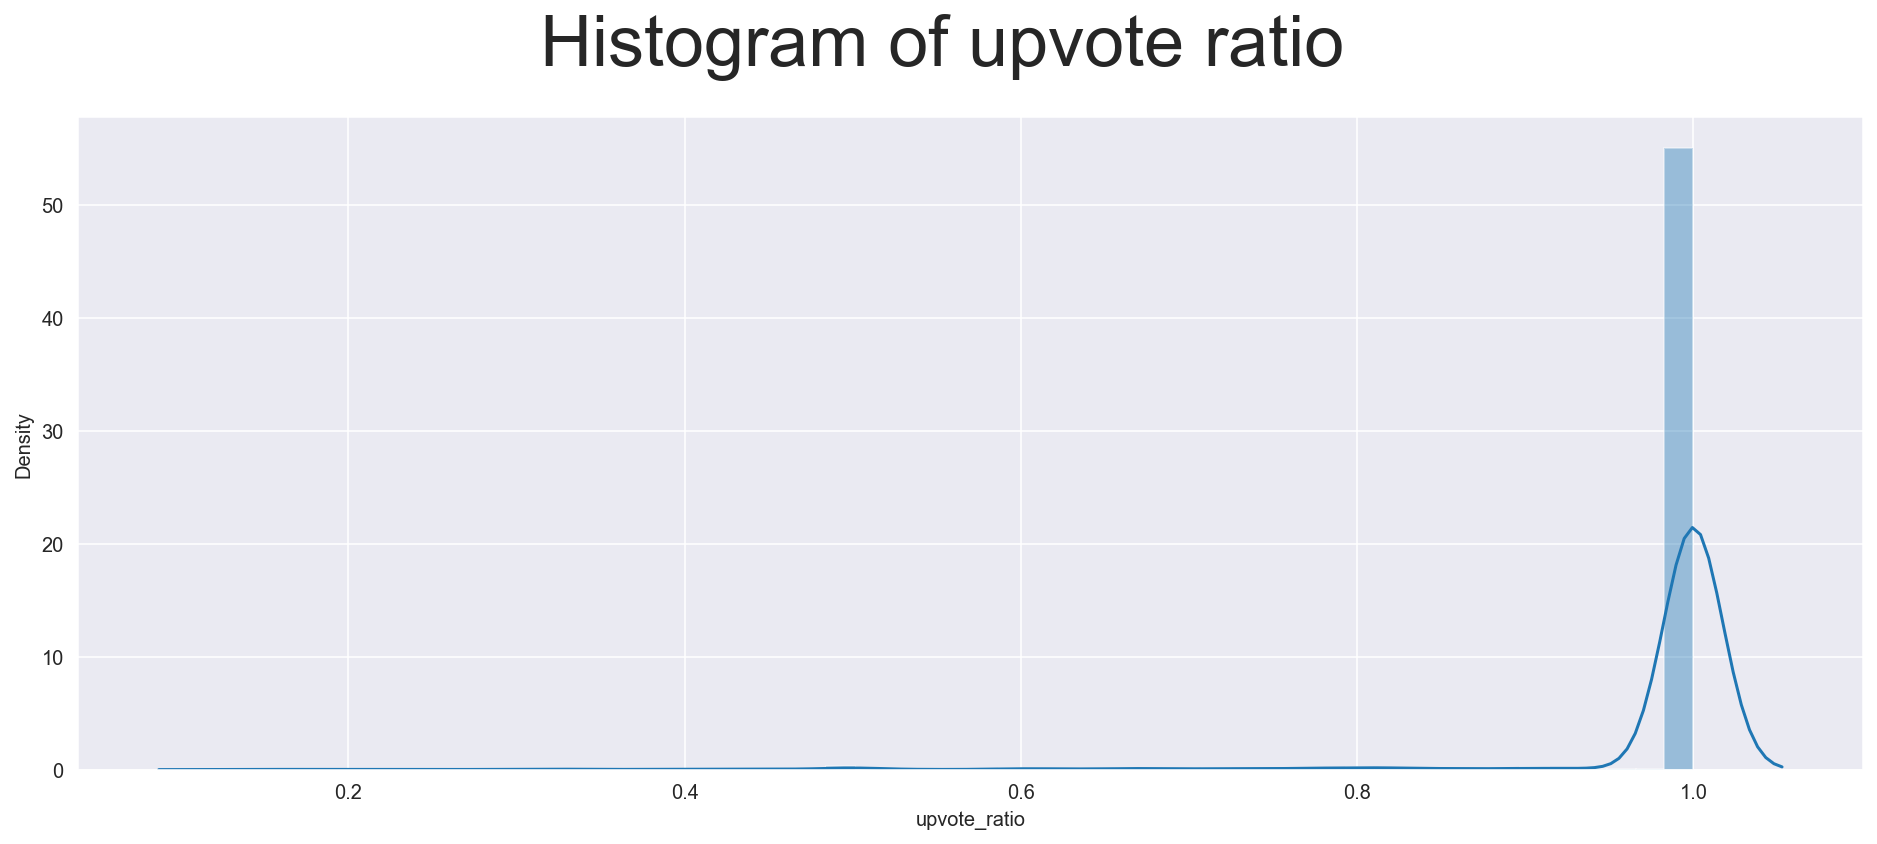

In [41]:
fig = plt.figure(figsize=(16,6))
sns.distplot(df['upvote_ratio'])
fig.suptitle('Histogram of upvote ratio', fontsize=36, y=1)
fig.savefig('./images/histogram_upvote_ratio.png')
plt.show();

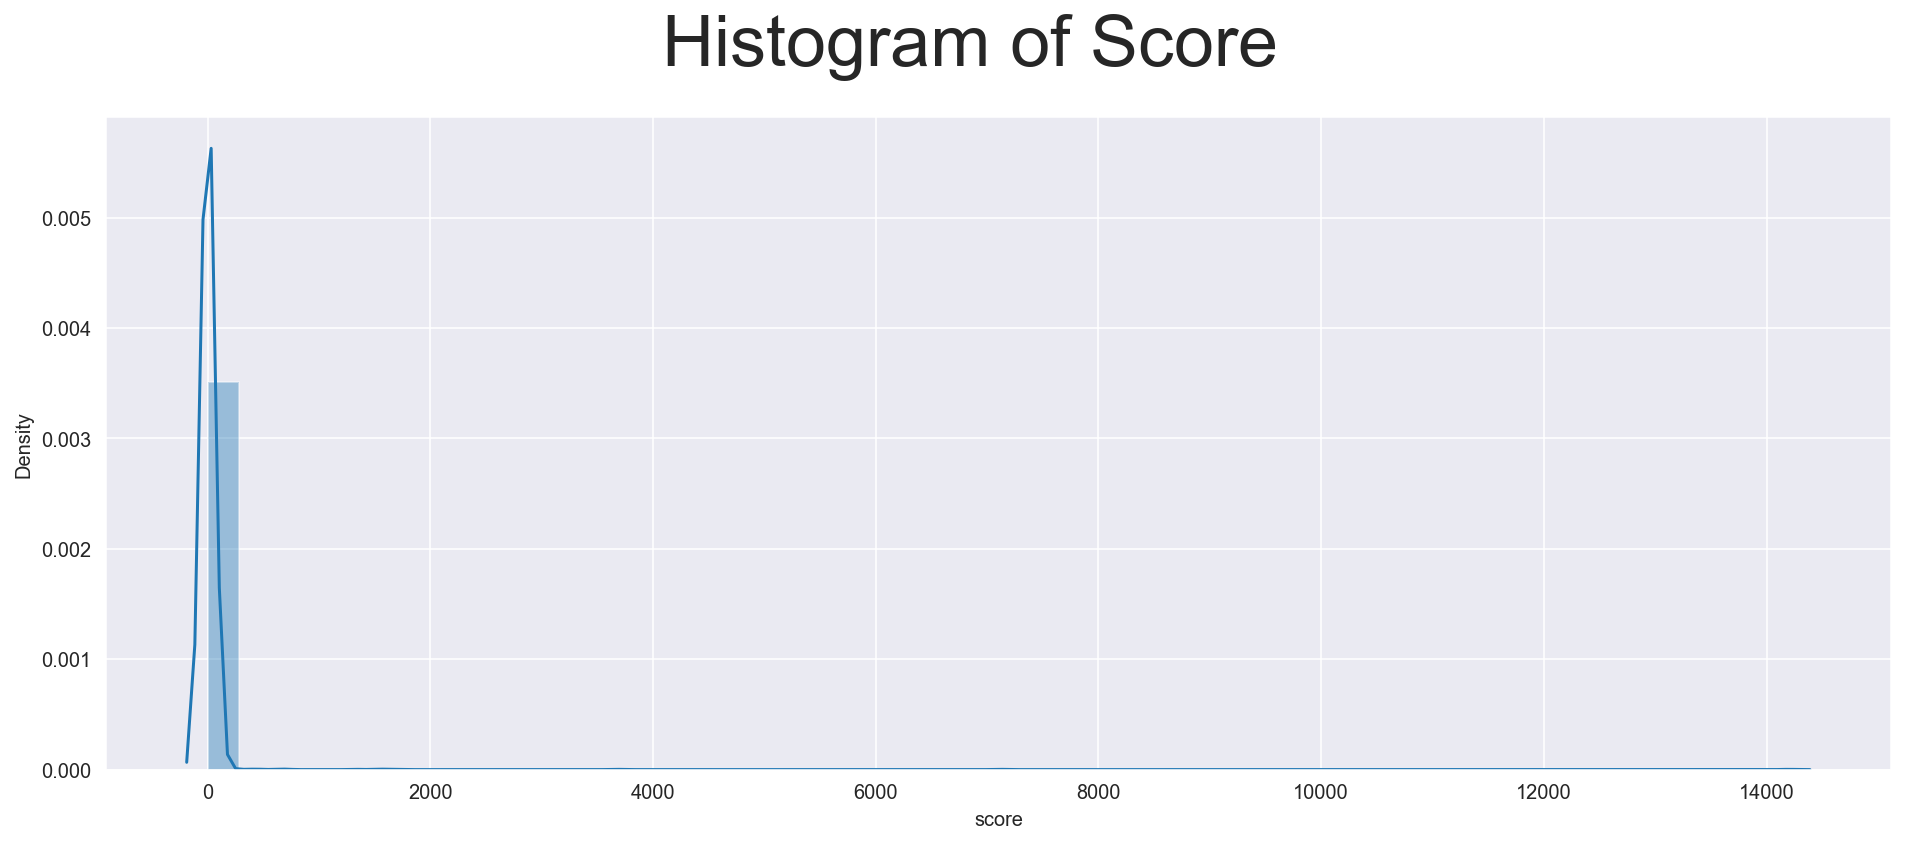

In [42]:
fig = plt.figure(figsize=(16,6))
sns.distplot(df['score'])
fig.suptitle('Histogram of Score', fontsize=36, y=1)
fig.savefig('./images/histogram_score.png')
plt.show();

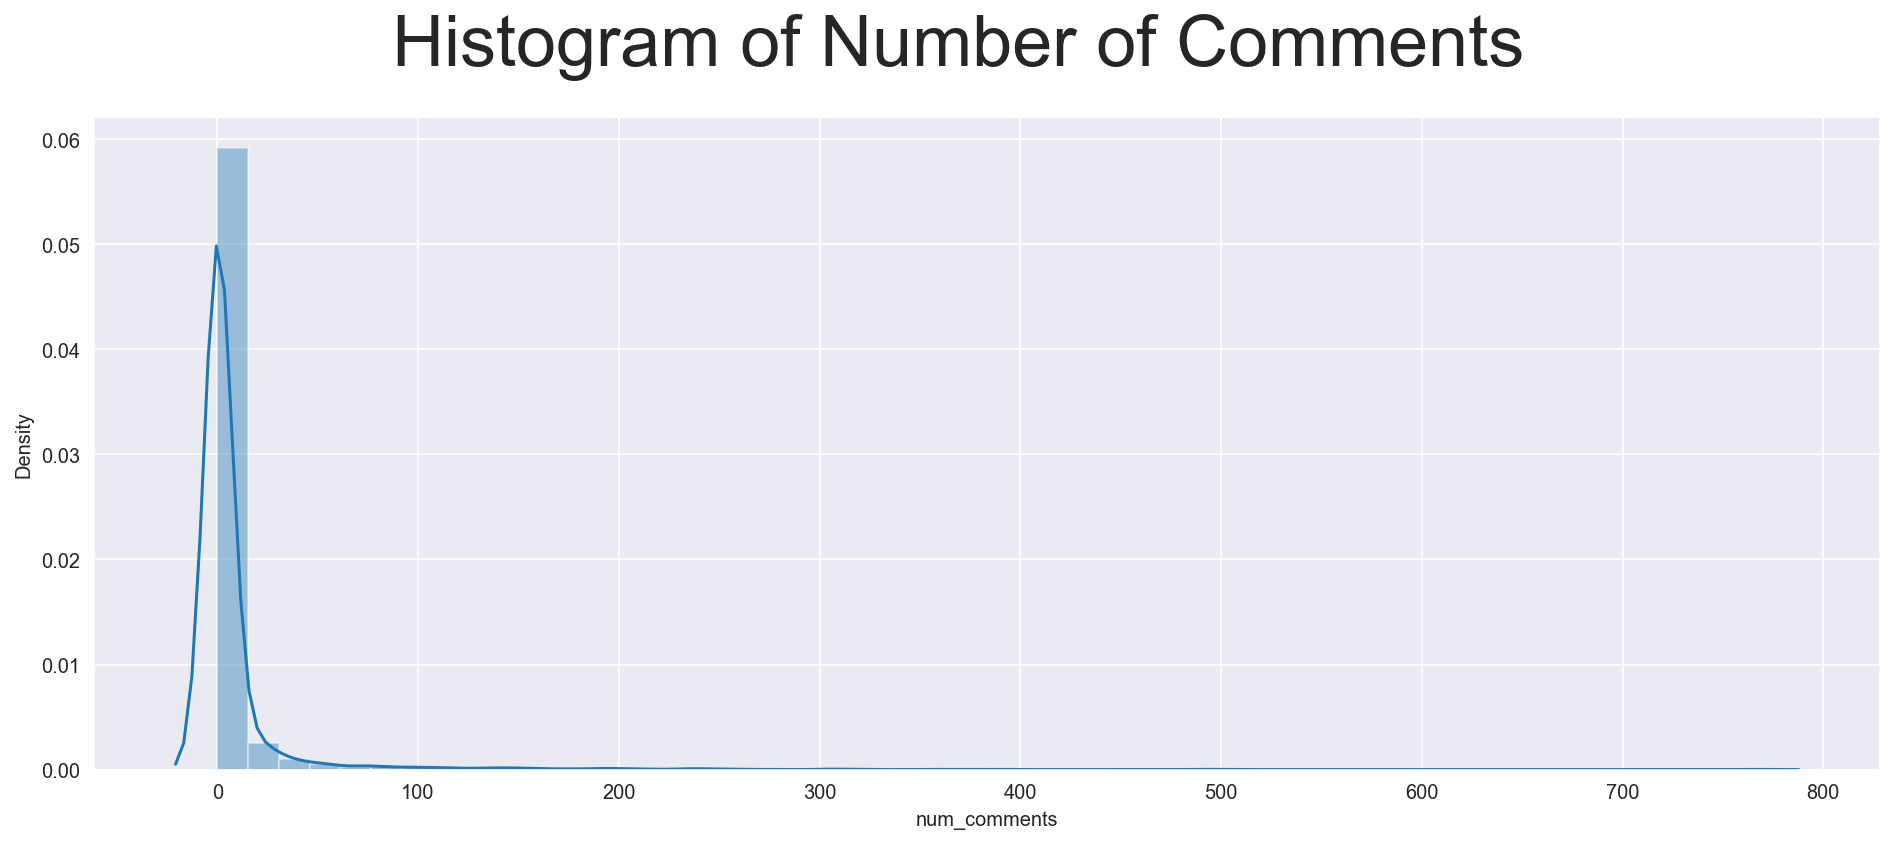

In [43]:
fig = plt.figure(figsize=(16,6))
sns.distplot(df['num_comments'])
fig.suptitle('Histogram of Number of Comments', fontsize=36, y=1)
fig.savefig('./images/histogram_num_comments.png')
plt.show();

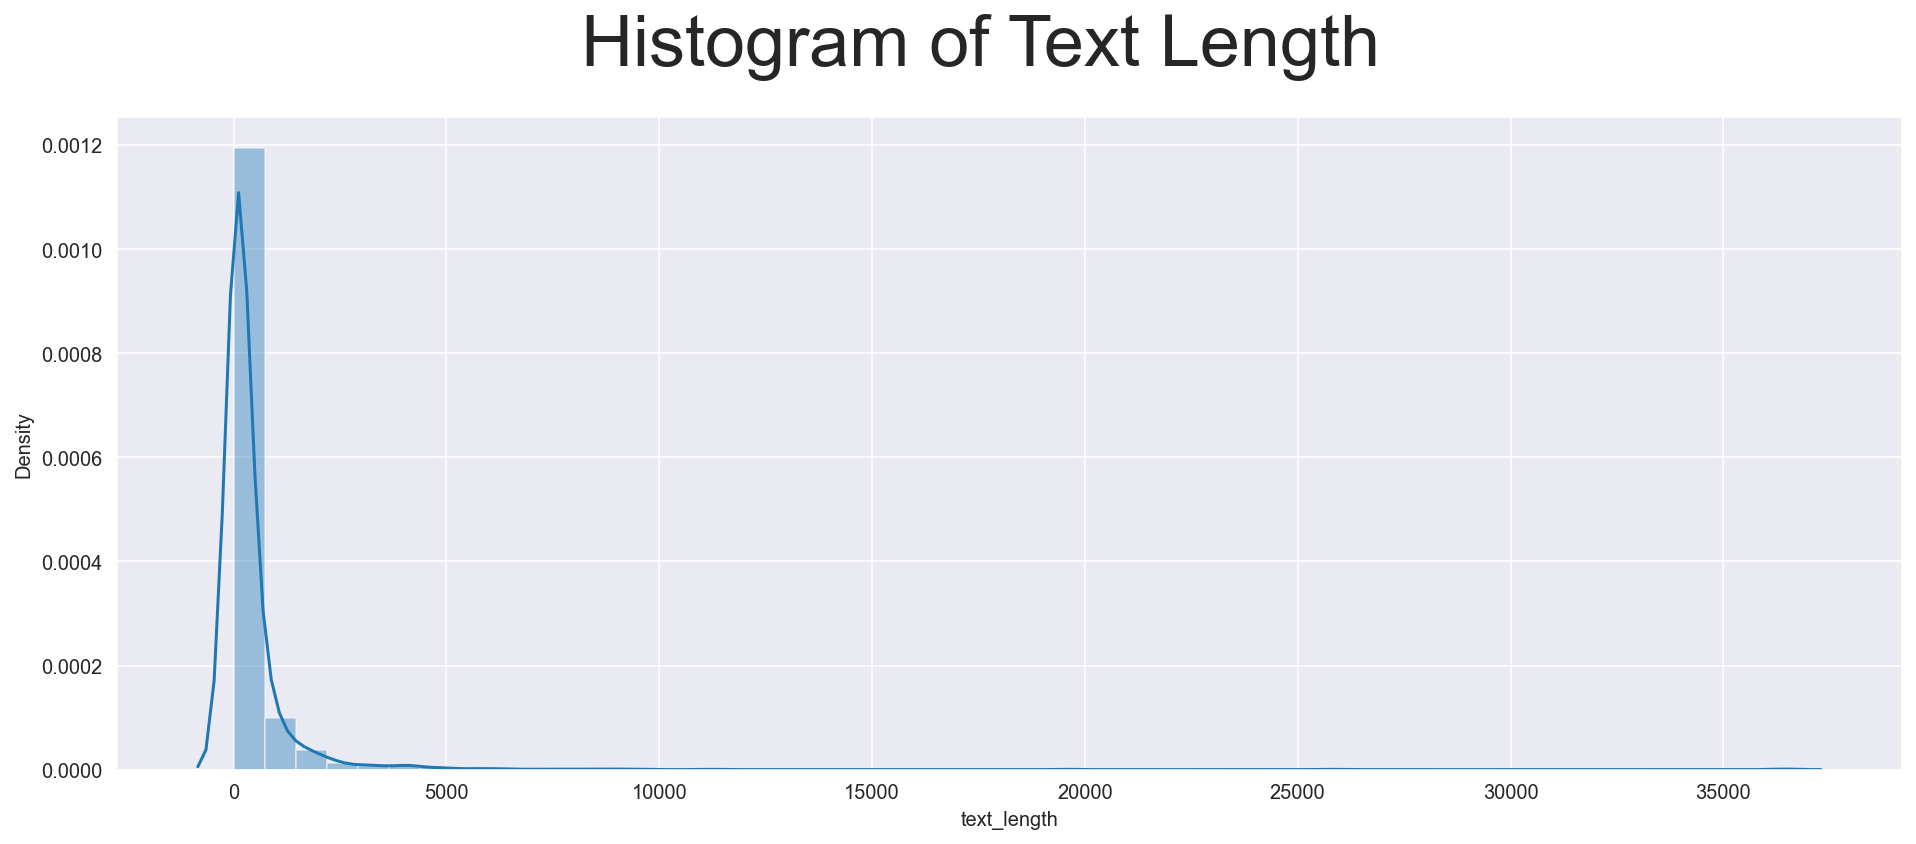

In [44]:
fig = plt.figure(figsize=(16,6))
sns.distplot(df['text_length'])
fig.suptitle('Histogram of Text Length', fontsize=36, y=1)
fig.savefig('./images/histogram_text_length.png')
plt.show();

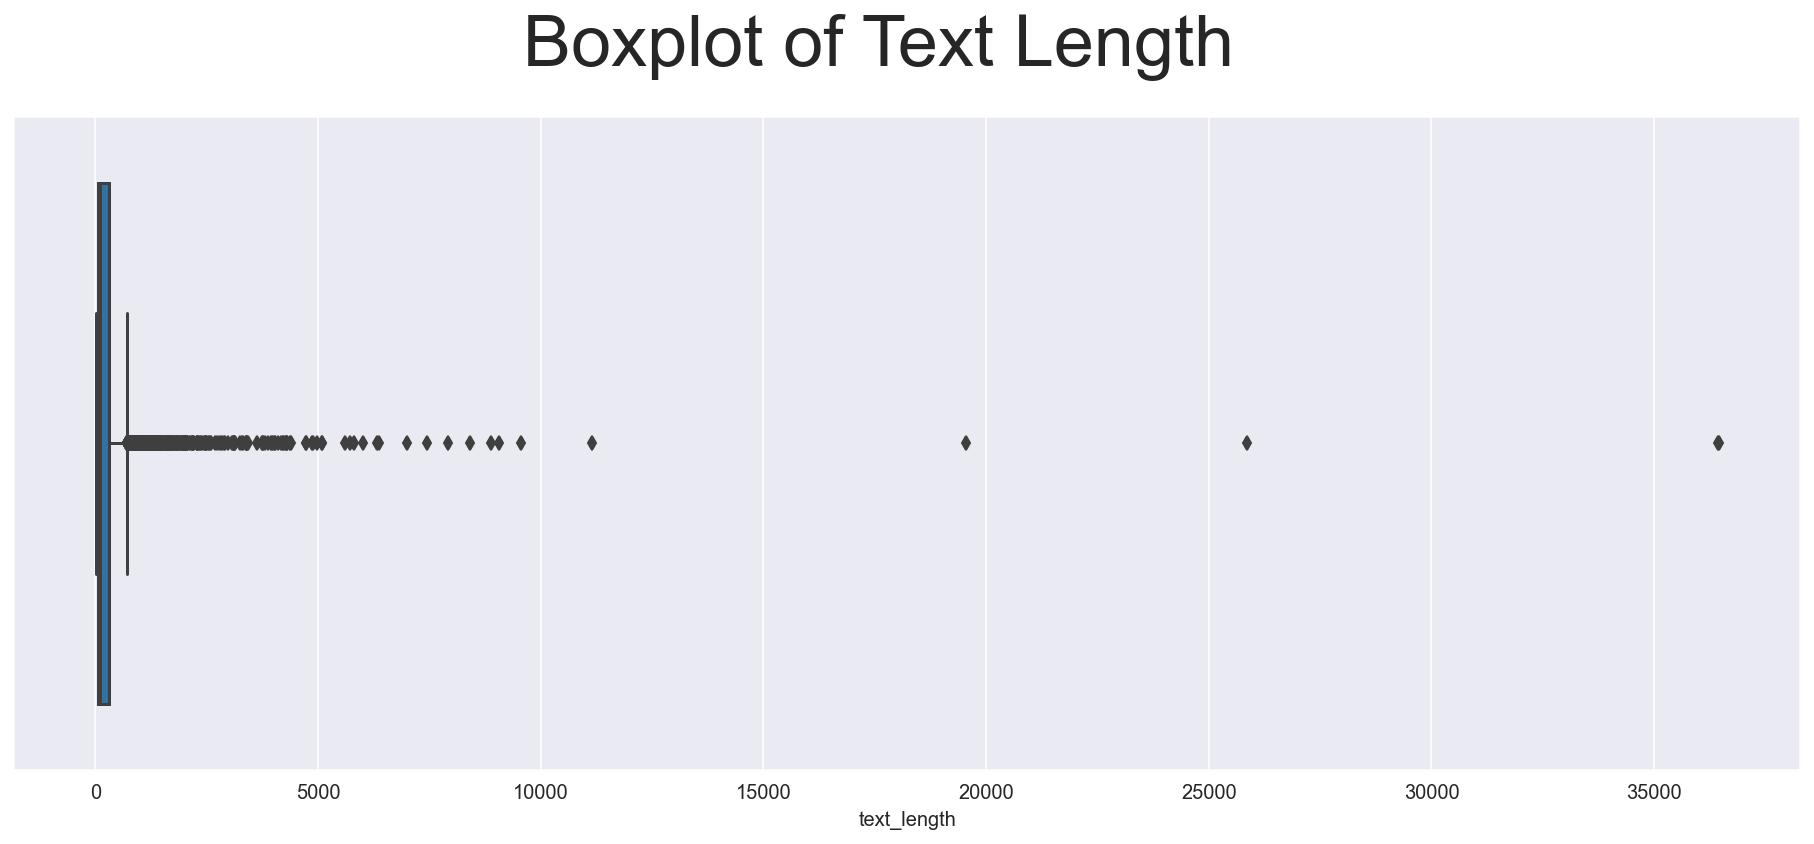

In [45]:
fig = plt.figure(figsize=(16,6))
sns.boxplot(df['text_length'])

fig.suptitle('Boxplot of Text Length', fontsize=36, y=1)
fig.savefig('./images/boxplot_text_length.png')
plt.show();

In [46]:
percentile25 = df['text_length'].quantile(0.25)
percentile75 = df['text_length'].quantile(0.75)

In [47]:
percentile75, percentile25 = np.percentile(df['text_length'], [75 ,25])
iqr = percentile75 - percentile25

In [48]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [49]:
df[df['text_length'] > upper_limit]
df[df['text_length'] < lower_limit]

Empty DataFrame
Columns: [id, subreddit, title, selftext, score, upvote_ratio, num_comments, word_length, text, text_length]
Index: []

In [50]:
new_df = df[df['text_length'] < upper_limit]
new_df.shape

(2484, 10)

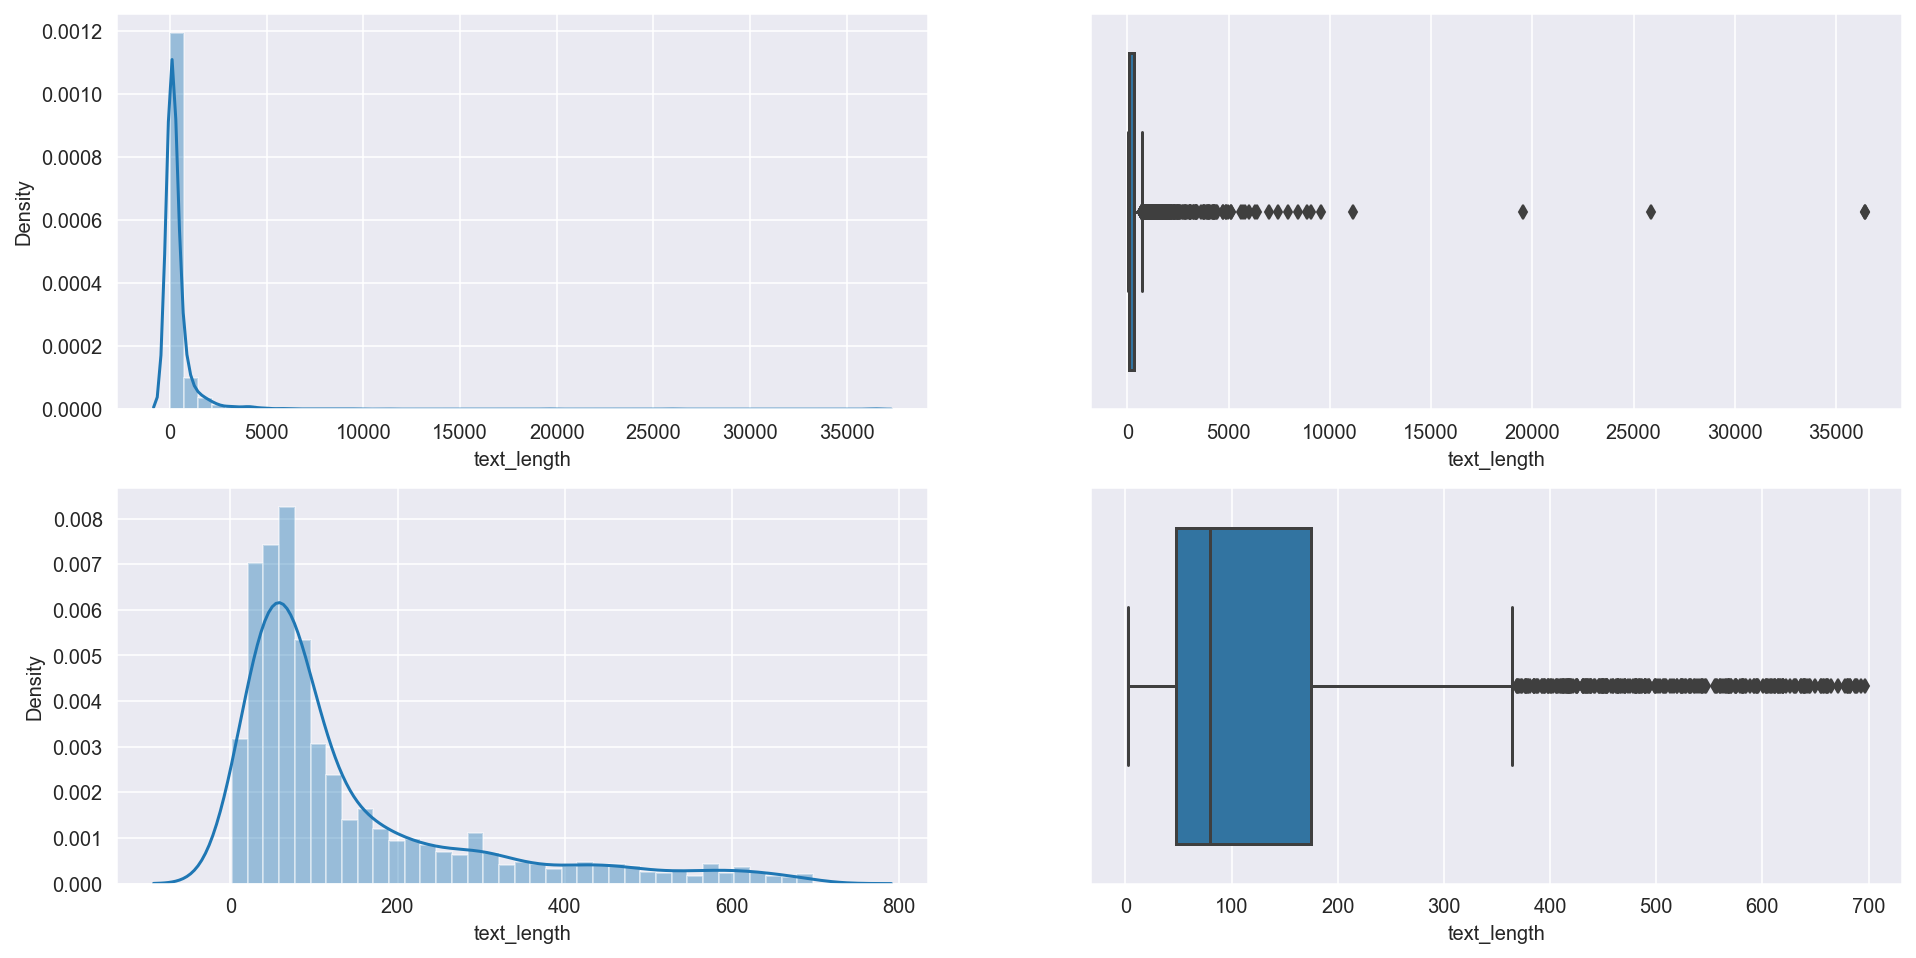

In [51]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['text_length'])
plt.subplot(2,2,2)
sns.boxplot(df['text_length'])
plt.subplot(2,2,3)
sns.distplot(new_df['text_length'])
plt.subplot(2,2,4)
sns.boxplot(new_df['text_length'])
plt.show()

In [52]:
new_df_cap = df.copy()
new_df_cap['text_length'] = np.where(
    new_df_cap['text_length'] > upper_limit,
    upper_limit,
    np.where(
        new_df_cap['text_length'] < lower_limit,
        lower_limit,
        new_df_cap['text_length']
    )
)

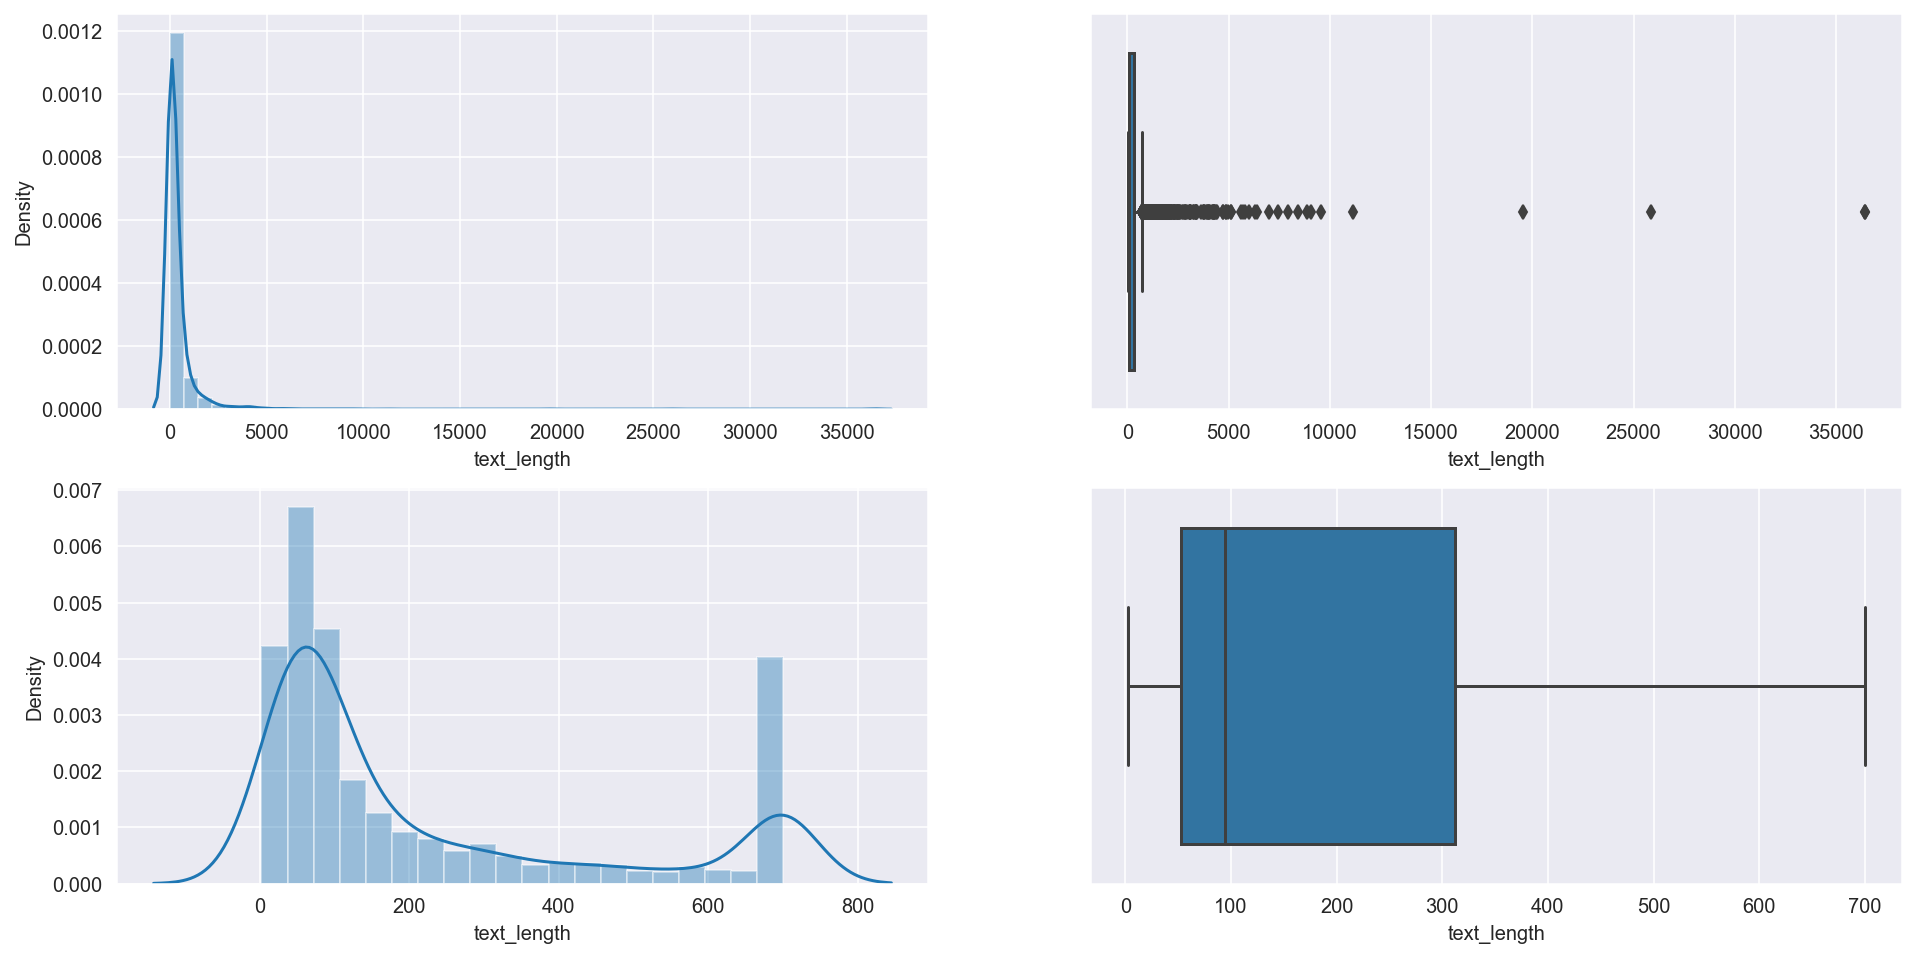

In [53]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['text_length'])
plt.subplot(2,2,2)
sns.boxplot(df['text_length'])
plt.subplot(2,2,3)
sns.distplot(new_df_cap['text_length'])
plt.subplot(2,2,4)
sns.boxplot(new_df_cap['text_length'])
plt.show()

In [54]:
new_df_cap.shape

(2877, 10)

In [55]:
# Checking the datas were combined correctly 
new_df_cap['subreddit'].value_counts()

aliens    1446
space     1431
Name: subreddit, dtype: int64

In [56]:
df = new_df_cap.copy()

### __Observation__

__There is an obvious outliners after 700 text_length. To keep the distribution proper, the outliner >700 was removed.__

In [57]:
# Removing the outliners of more than 3 std deviation (938) in score 
df = df.drop(df[(df['text_length']> 700)].index)

### __Analysis: Outliners on  score, upvote_ratio, num_comments.__

- Are outliers identified and addressed? 

__Score: Seems like shorter text length gets more ups. The data is not normally distributed and it is right skewed. Applying filtering of 3 std deviation on score. It now stewed less towards the right but it is more distributed after removing 3 std deviation outliners.__

__Upvote ratio and num comments: Both data seemed rather spread out. As such, did not need any filtering of outliners.__

---

### Using wordcloud to show the weightage of the words for both subreddits

Created a function to display the wordcloud of the subreddits.

- For r/aliens, the high weightage are Alien, UFO, strange, human.
- For r/space, the high weightage are Space, NASA, launch, telescope

In [58]:
def show_wordcloud(data, title = None,file = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords.words(),
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(16, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=1.25)

    plt.imshow(wordcloud)
    plt.show()
    fig.savefig('./images/word_cloud_'+file+'.png')

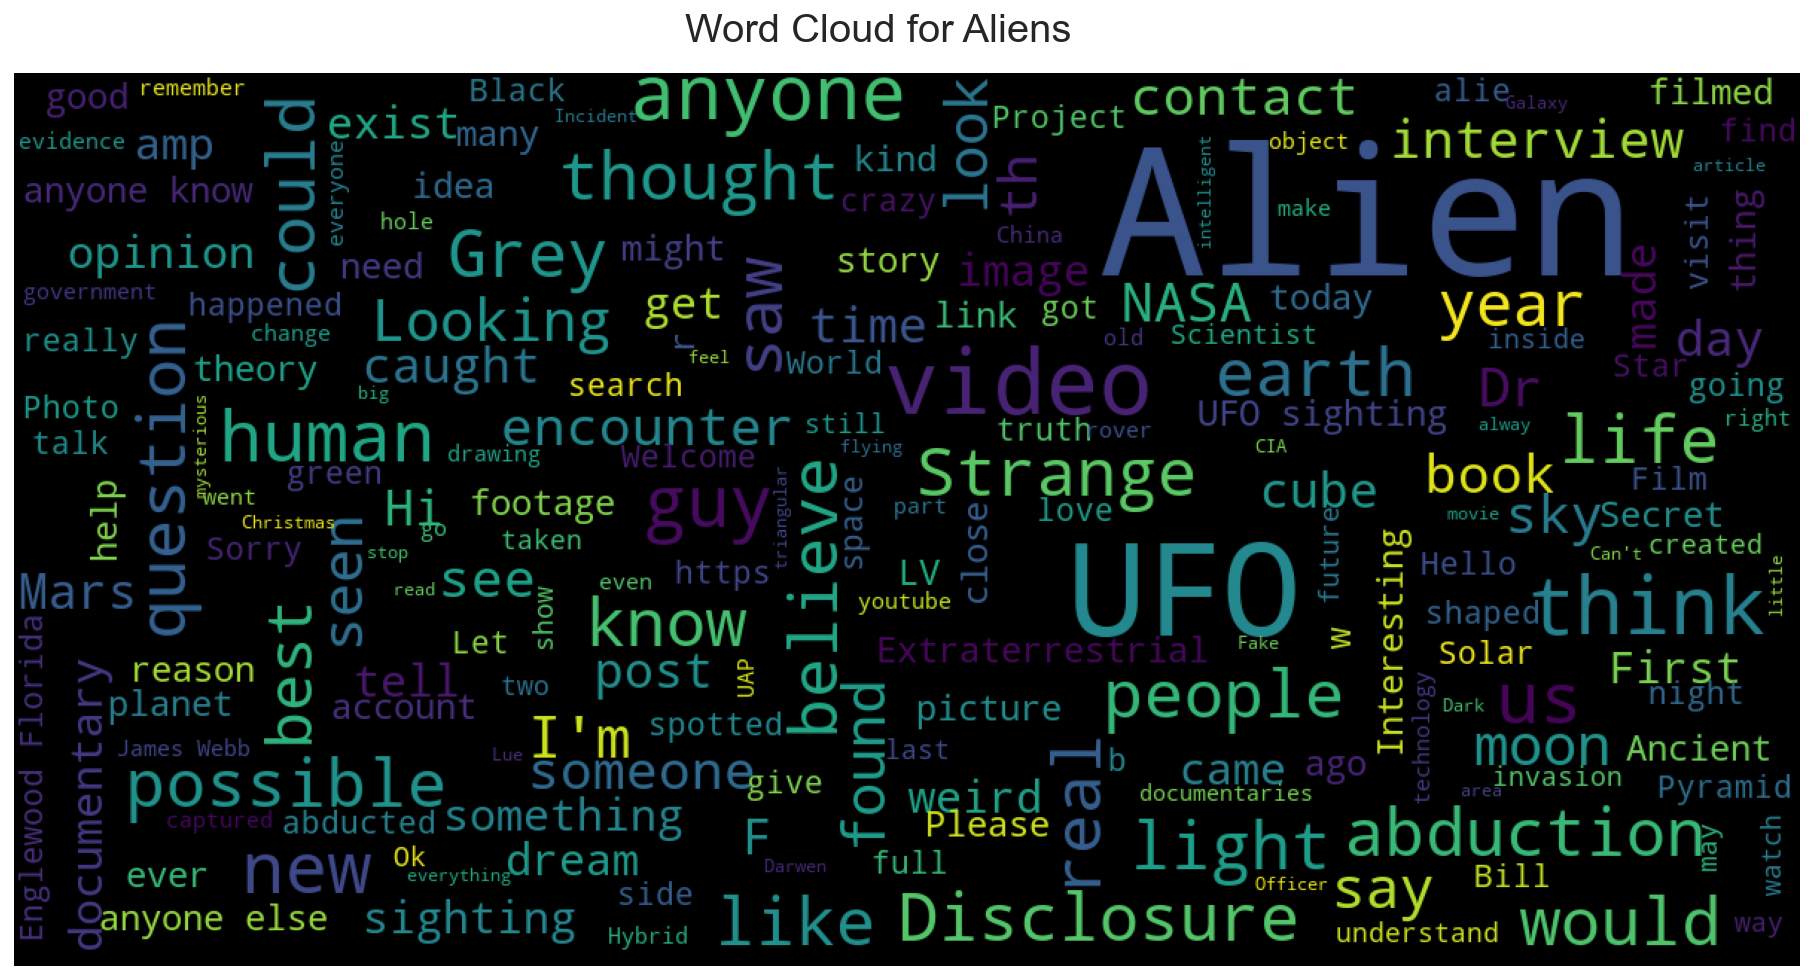

In [59]:
show_wordcloud(str(df[df.subreddit=='aliens'].text),'Word Cloud for Aliens','aliens')

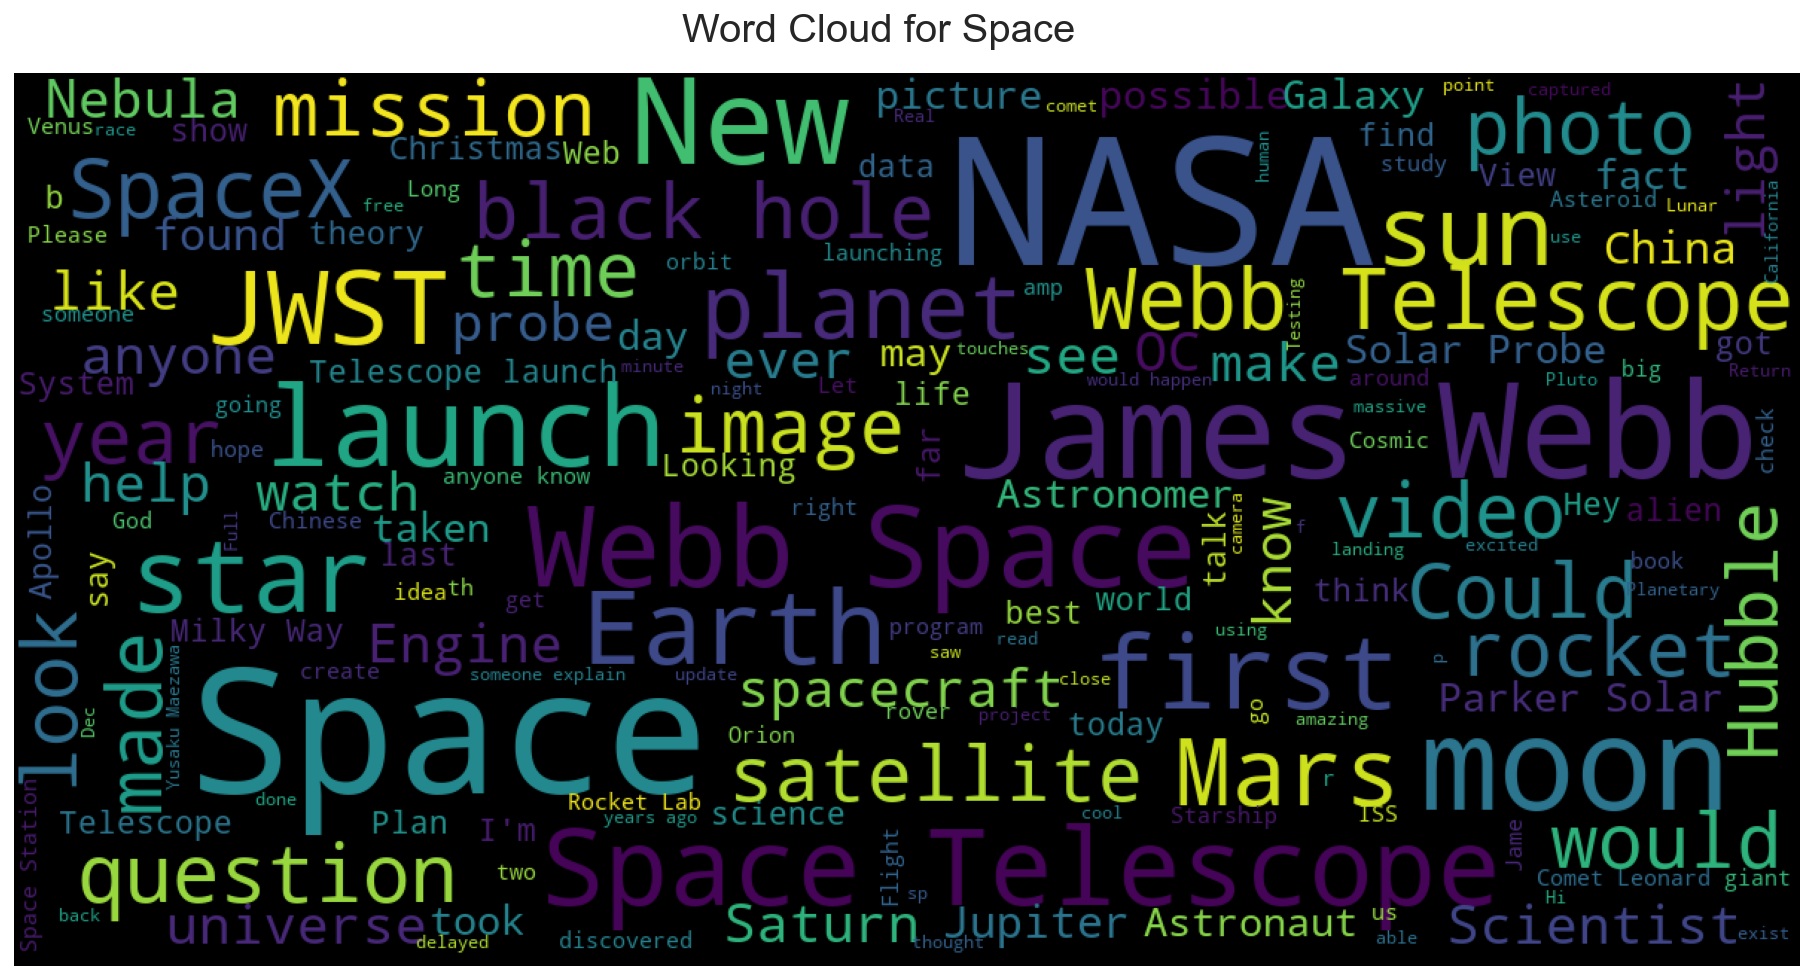

In [60]:
show_wordcloud(str(df[df.subreddit=='space'].text),'Word Cloud for Space','space')

### Cleaning of data

Created a function to clean the text for the NLP modeling.
- make all lowercase
- remove non-letters
- remove HTML
- remove website hyperlink
- remove words with 2 or fewer letters such as 'is', 'as', 'by' which do not contribute to the modeling
- remove whitespace
- remove emoji using a function demoji
- remove emoticons :)

In [61]:
def cleaner(text):
    # Make lowercase
    text = text.lower()
    
    # Remove non-letters
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'http\S+',' ',text)

    # Remove hyperlinks
    text = re.sub(r'www',' ',text)

    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)

    # Remove emoji
    text = demoji.replace(text, '')
    
    # Remove emoticons
    text = text.replace(":)", '')
    
    # Remove words space and aliens that are in the subreddit's name and also in the column
#     subreddit_words_remove = ['space','aliens']
#     text = re.sub(r'space','',text)
#     text = re.sub(r'aliens','',text)
#     text = re.sub(r'alien','',text)    
#     text = [w for w in text if not w in subreddit_words_remove]
  
    return text

In [62]:
# Apply cleaner function
df['text'] = df['text'].apply(cleaner)

In [63]:
# Display of the text after cleaning
df.text

0                    does anyone know what this ive seen 
1                          nasa plans nuclear plant moon 
2        think black holes might pockets pockets speci...
3       astronomers have produced the most comprehensi...
4        considered this one the sharpest moon image t...
5        friend was npr discussing jwst the launch the...
6           nasa billion plan scan the edge our universe 
7       with its single eye nasa dart returns first im...
8       jwst launch date and time james webb space tel...
10       long last the world most powerful space teles...
11                                  marina koren twitter 
12      can anyone help identifying what this project ...
13      old home video space shuttle columbia launchin...
14      the insane engineering james webb telescope ap...
15       the first ever gaming and nft elite forces ho...
16      does anyone know which orbit the jwst will use...
17      why nasa james webb space telescope will orbit...
18      loved 

In [64]:
df['text'].isna().sum()

0

### Histogram after cleaning and combining of the two subreddits
Both are right-stew distribution.It showed the text length / count. Both hovered 40-60 high peak although space seemed to have more counts from 50 to 100 text length.

In [65]:
# Changing subreddit to int 1 for space and 0 for aliens
df['is_aliens'] = df['subreddit'].map({'aliens': 1, 'space': 0})

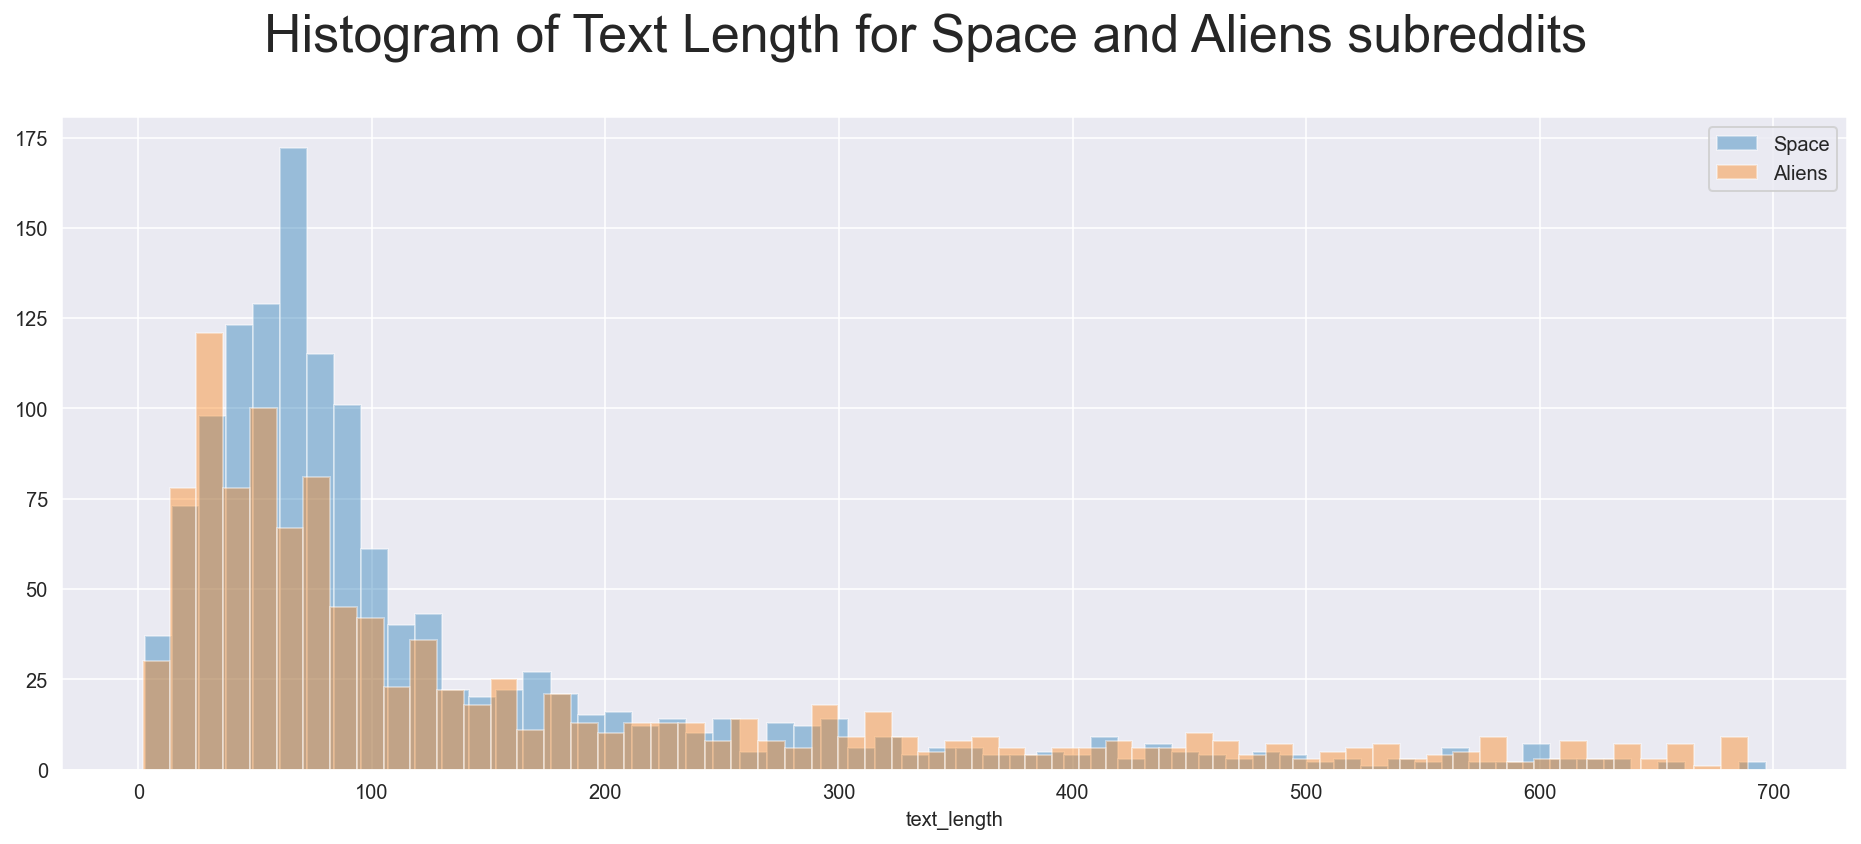

In [66]:
fig = plt.figure(figsize=(16,6))
sns.distplot(df[df['is_aliens'] == 0]['text_length'], kde=False, label = 'Space', bins=60)
sns.distplot(df[df['is_aliens'] == 1]['text_length'], kde=False, label = 'Aliens', bins =60)
fig.suptitle('Histogram of Text Length for Space and Aliens subreddits', fontsize=26, y=1)
fig.savefig('./images/histogram_text_length_2_subreddits.png')
plt.legend();

---
### __Analysis__

__Using tokenize and lemmatize.__

__The aim of lemmatization is to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. Although stemming is faster, it chops words without knowing the context of the word in given sentences. Lemmatization on the other hand is slower as compared to stemming but it knows the context of the word before proceeding. It is a rule-based approach. Lemmatization provides better results by performing an analysis that depends on the word's part-of-speech and producing real, dictionary words. As we are examining aliens and space which requires substainable and meaningful words, Lemmatization is used only.__

__Stopwords are also in use so that we can remove the  common words from the list.__

In [67]:
# Setting for stopwords in english
en_stops = set(stopwords.words('english'))

In [68]:
# Function to tokenize, remove stopwords and lemmatize the title
# after processing the title, join the words together back to string to be processed for CountVectorizer
    
def tokenlen(text):
    # Instantiate tokenizer and lemmatizer
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    
    # Run tokenizer
    tokens = [token.lower() for token in tokenizer.tokenize(text)]
#     print(tokens)

    tokens_stops = []
    for word in tokens: 
        if word not in en_stops:
            tokens_stops.append(word)
#             print(tokens_stops)

    # Lemmatize tokens
#     lem_tokens = [lemmatizer.lemmatize(i) for i in tokens]
    lem_list = []
    for token in tokens_stops:
        lem_tokens = lemmatizer.lemmatize(token)
        lem_list.append(lem_tokens)
        if token != lem_tokens:
            print(token, lem_tokens) # check the list for lemmatize words
    return ' '.join(lem_list)

In [69]:
# List the words that lemmatize generated
df['text'] = df['text'].apply(lambda x: tokenlen(x))

plans plan
holes hole
pockets pocket
pockets pocket
things thing
astronomers astronomer
degrees degree
moons moon
returns return
images image
mins min
years year
apologies apology
blows blow
forces force
miles mile
pictures picture
telescopes telescope
scientists scientist
years year
astronomers astronomer
planets planet
conditions condition
rules rule
conditions condition
aliens alien
planets planet
degrees degree
metrics metric
conditions condition
signs sign
insults insult
crafts craft
photons photon
photons photon
articles article
sites site
photons photon
photos photo
doppelgangers doppelganger
missions mission
mars mar
moves move
areas area
tons ton
moons moon
moons moon
moons moon
ways way
partners partner
telescopes telescope
astronomers astronomer
planets planet
planets planet
planets planet
partners partner
things thing
lights light
astronomers astronomer
years year
shifts shift
holes hole
holes hole
details detail
words word
secrets secret
begins begin
shoots shoot
galaxies 

years year
touches touch
meteors meteor
strikes strike
astronauts astronaut
details detail
sheds shed
asteroids asteroid
years year
touches touch
dives dive
days day
touches touch
scientists scientist
stars star
mars mar
enthusiasts enthusiast
enthusiasts enthusiast
windows window
users user
notifications notification
astronomers astronomer
images image
tweets tweet
rings ring
tides tide
books book
years year
topics topic
books book
focuses focus
panels panel
worlds world
cells cell
touches touch
dives dive
experts expert
touches touch
satellites satellite
claims claim
habitats habitat
windows window
images image
stars star
meters meter
plans plan
arms arm
seeks seek
patterns pattern
effects effect
tides tide
makes make
forces force
views view
perspectives perspective
sides side
peoples people
views view
options option
emissions emission
operators operator
filings filing
images image
images image
times time
swaps swap
swaps swap
bodies body
answers answer
mars mar
flies fly
ripples rip

bodies body
mars mar
moons moon
reflections reflection
spots spot
mechanics mechanic
mysteries mystery
holes hole
teenagers teenager
teenagers teenager
lifts lift
videos video
images image
galaxies galaxy
planets planet
trillions trillion
planets planet
lights light
engineers engineer
media medium
years year
css cs
iss i
tourists tourist
rounds round
facilities facility
lights light
aliens alien
returns return
operations operation
nozzles nozzle
spots spot
facts fact
shorts short
signs sign
comes come
says say
pictures picture
objects object
devices device
bodies body
opportunities opportunity
starts start
things thing
astronauts astronaut
exams exam
tests test
astronauts astronaut
planets planet
planets planet
stars star
plans plan
entities entity
holes hole
goes go
claims claim
works work
giants giant
giants giant
returns return
operations operation
spots spot
scientists scientist
signs sign
goes go
capabilities capability
studies study
assess ass
asteroids asteroid
videos video
trac

attacks attack
mars mar
days day
details detail
aliens alien
posts post
similarities similarity
attacks attack
videos video
aliens alien
aliens alien
abilities ability
greys grey
greys grey
humans human
viruses virus
mutations mutation
viruses virus
adaptations adaptation
vaccines vaccine
symptoms symptom
hosts host
changes change
computers computer
files file
episodes episode
files file
events event
means mean
aliens alien
conflicts conflict
encounters encounter
schools school
cases case
nukes nuke
cases case
motives motif
schools school
children child
teachers teacher
children child
teachers teacher
persons person
minds mind
aliens alien
thoughts thought
looks look
hands hand
questions question
conspiracies conspiracy
knows know
programs program
stars star
aliens alien
kids kid
aliens alien
uss us
thoughts thought
sources source
reptilians reptilian
spirits spirit
goes go
transmissions transmission
scientists scientist
terabytes terabyte
aliens alien
files file
videos video
contender

testimonies testimony
links link
says say
effects effect
artists artist
bases base
thoughts thought
days day
years year
aliens alien
years year
aliens alien
images image
fans fan
believes belief
things thing
aliens alien
guys guy
friends friend
guys guy
articles article
secrets secret
guys guy
cats cat
organisms organism
scientists scientist
months month
physics physic
aliens alien
slaves slave
positions position
aliens alien
believes belief
aliens alien
aliens alien
knows know
aliens alien
aliens alien
humans human
microbes microbe
microbes microbe
humans human
aliens alien
aliens alien
thoughts thought
aliens alien
aliens alien
creatures creature
equations equation
probes probe
mazes maze
electrodes electrode
worlds world
civilizations civilization
circles circle
pics pic
plants plant
circles circle
implications implication
thoughts thought
claims claim
claims claim
claims claim
worlds world
robots robot
americas america
robots robot
grays gray
ways way
guys guy
states state
aliens a

makes make
species specie
species specie
billionaires billionaire
aliens alien
agreements agreement
beings being
gates gate
names name
sellouts sellout
wolves wolf
aliens alien
bodies body
eyes eye
dies dy
ways way
humans human
guys guy
books book
documentaries documentary
works work
works work
aliens alien
ufos ufo
secrets secret
hybrids hybrid
interviews interview
girls girl
aliens alien
ufos ufo
points point
thoughts thought
pyramids pyramid
gods god
offers offer
insights insight
religions religion
highlights highlight
parallels parallel
aliens alien
humans human
aliens alien
encounters encounter
joins join
encounters encounter
phenomena phenomenon
lights light
goes go
humans human
species specie
aliens alien
aliens alien
greys grey
eyes eye
suggestions suggestion
aliens alien
humans human
aliens alien
comments comment
ios io
circles circle
persons person
circles circle
dots dot
mods mod
accounts account
affirmations affirmation
extraterrestrials extraterrestrial
extraterrestrials e

In [70]:
# List the 1st text to check
df['text'][0]

'anyone know ive seen'

In [71]:
df['text'].isna().sum()

0

In [72]:
df.head()

id subreddit                                              title  \
0  rmzn01     space               Does anyone know what this ive seen?   
1  rmzl73     space                 NASA Plans a Nuclear Plant on Moon   
2  rmz1sr     space               I think black holes might be pockets   
3  rmxpmy     space  Astronomers have produced the most comprehensi...   
4  rmxo1b     space  I considered this one of the sharpest moon ima...   

                                            selftext  score  upvote_ratio  \
0                                                         1           1.0   
1                                                         1           1.0   
2  Pockets specifically for holding things in "fo...      1           1.0   
3                                                         1           1.0   
4                                                         1           1.0   

   num_comments  word_length  \
0             1            7   
1             0            7   
2             0            7   
3             0           45   
4             0           22   

                                                text  text_length  is_aliens  
0                               anyone know ive seen         37.0          0  
1                       nasa plan nuclear plant moon         35.0          0  
2  think black hole might pocket pocket specifica...        219.0          0  
3  astronomer produced comprehensive image radio ...        283.0          0  
4  considered one sharpest moon image world final...        115.0          0

In [73]:
# Save to master file
df.to_csv('./data/df.csv')

---
## Exploratory Data Cleaning

### __Observation__

1) Looking from the histogram graph, space text length are generally longer than aliens. However, there is a big jump for both at 700 text length. We removed it.

2) There is weak correlation between text length and upvote ratio. Shorter text tends to get more ups.

3) The distribution of text length seems to be right skewed according to the distribution plot above

4) The strongest correlation with score is num comments. We will explore that further later.

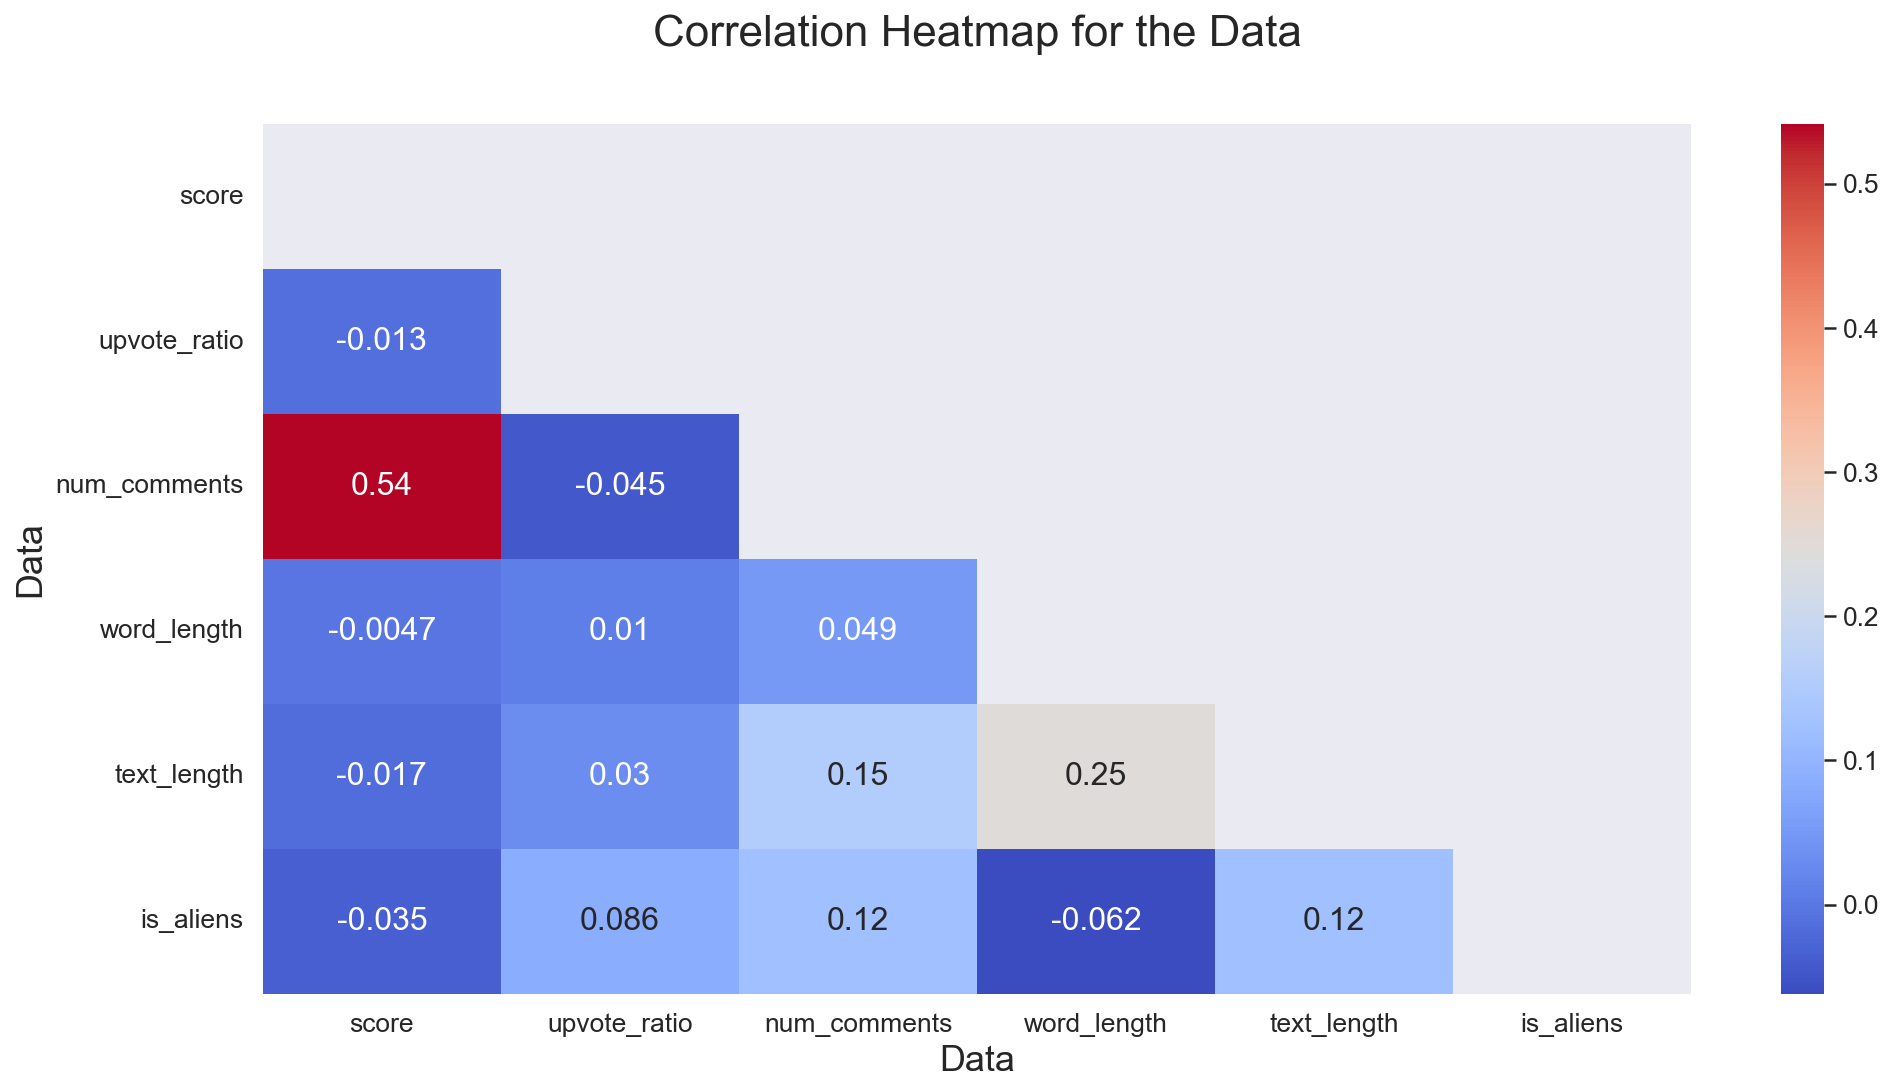

In [74]:
# define the mask to set the values in the upper triangle to True

sns.set(font_scale=1.2)
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(16, 8))
ax = sns.heatmap(
    df.corr(),
    cmap='coolwarm', #BrBG also can
    annot=True,
    mask = mask,
    annot_kws={"size":16}
)
ax.set_title('Correlation Heatmap for the Data\n', fontdict={'fontsize':22}, pad=16)
ax.set_xlabel('Data', fontdict={'fontsize':18})
ax.set_ylabel('Data', fontdict={'fontsize':18})
fig.savefig('./images/correlation_heatmap.png');

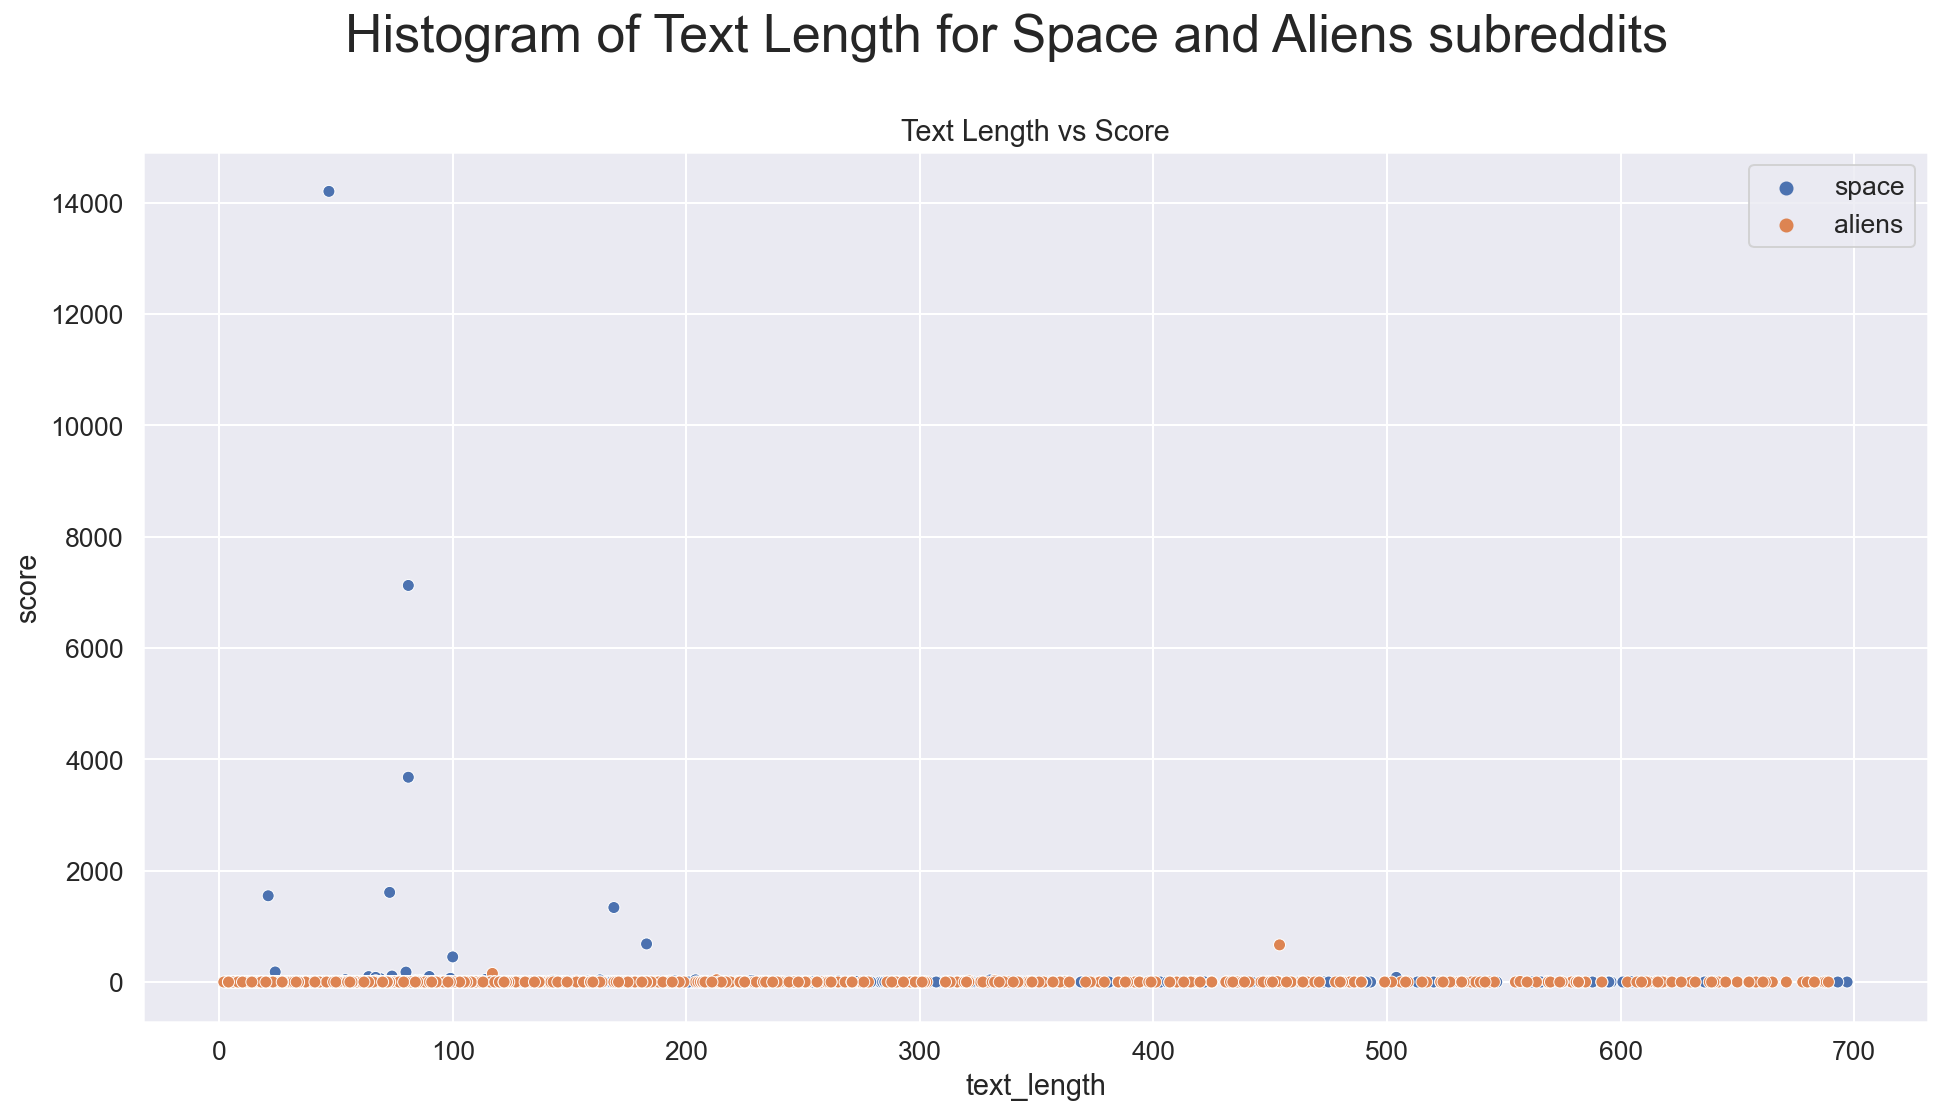

In [75]:
# Lets take a look at text length to score
fig = plt.figure(figsize=(16,8))
plt.title('Text Length vs Score')
sns.scatterplot(x='text_length',y='score',data=df, hue='subreddit')
fig.suptitle('Histogram of Text Length for Space and Aliens subreddits', fontsize=26, y=1)
fig.savefig('./images/histogram_text_length_2_subreddits.png')
plt.legend();

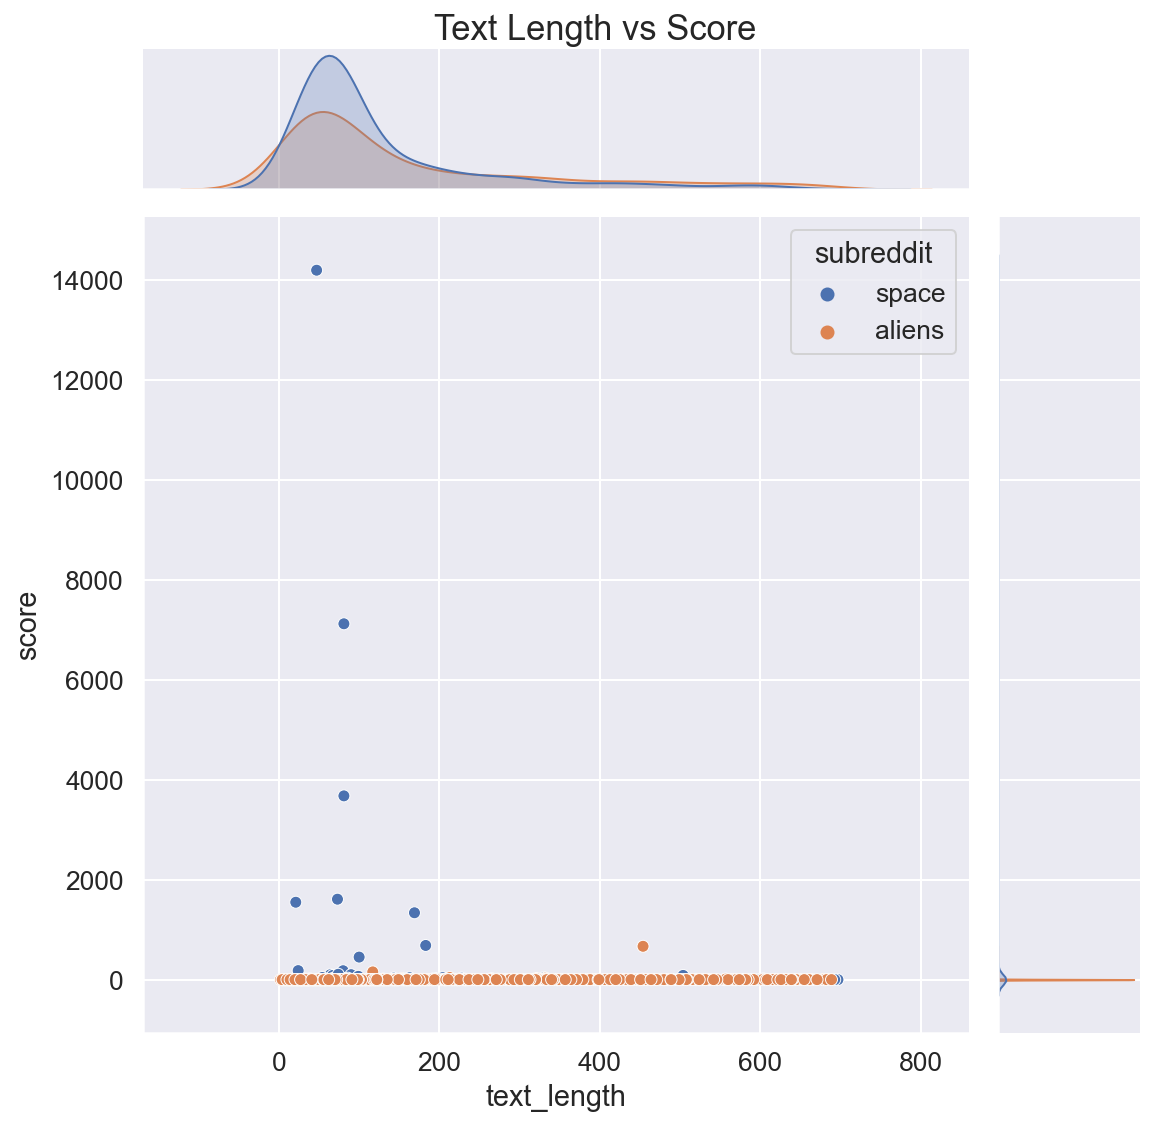

In [76]:
g = sns.jointplot(x=df['text_length'], y=df['score'], color='blue', hue=df['subreddit'], height=8);
g.fig.suptitle("Text Length vs Score")
g.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

In [77]:
print("Highest allowed",df['score'].mean() + 3*df['score'].std())
print("Lowest allowed",df['score'].mean() - 3*df['score'].std())

Highest allowed 1010.1924506351627
Lowest allowed -981.2987308283994


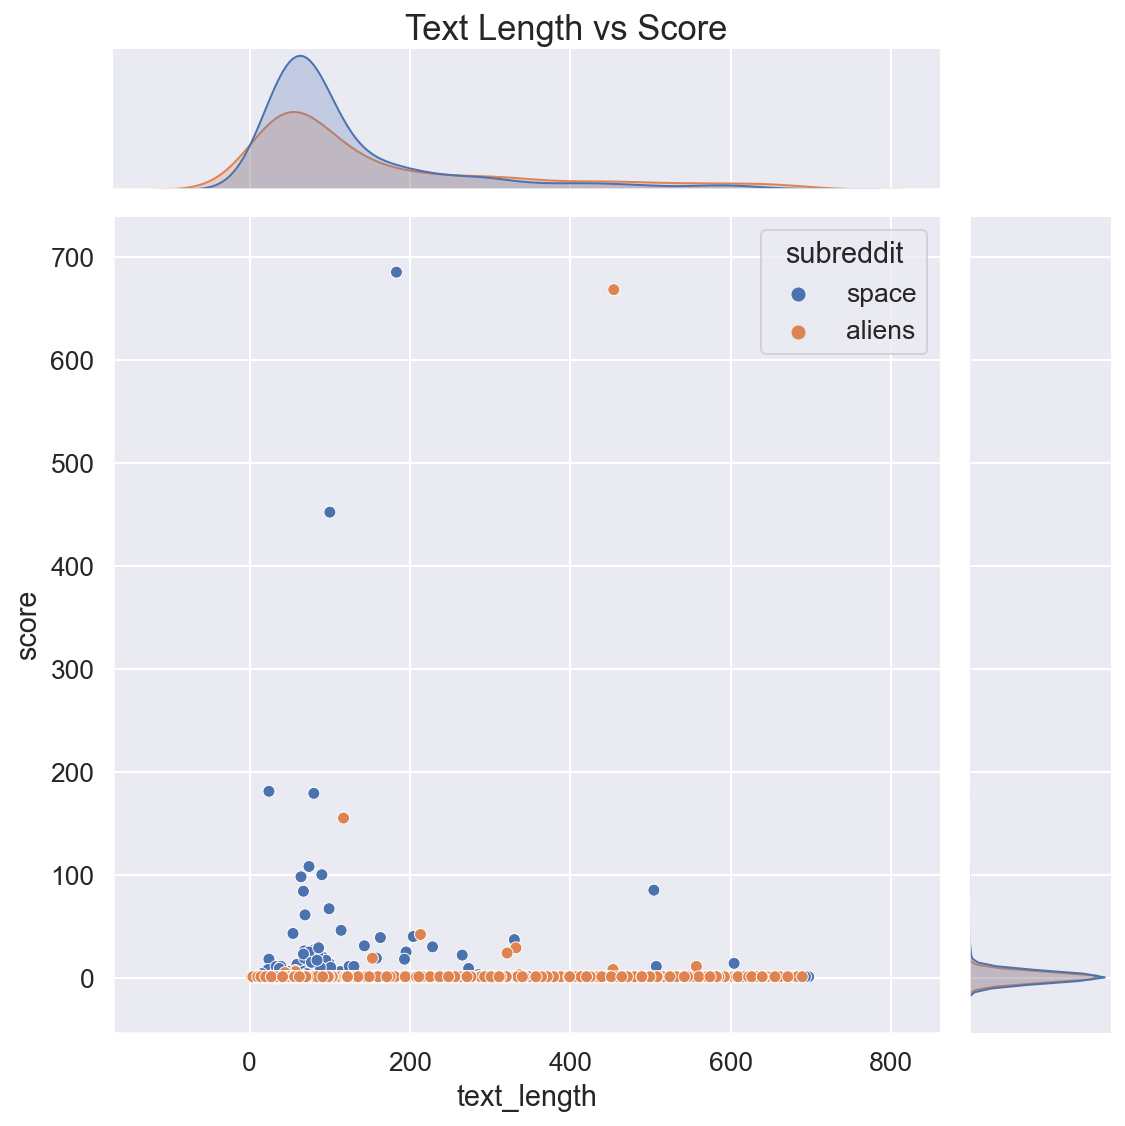

In [78]:
x_score = df[df['score'] < 1010]
g=sns.jointplot(x=df['text_length'], y=x_score['score'], color='blue', hue=df['subreddit'], height=8);
g.fig.suptitle("Text Length vs Score")
g.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

In [79]:
# Removing the outliners of more than 3 std deviation (938) in score 
df = df.drop(df[(df['score']> 1010)].index)

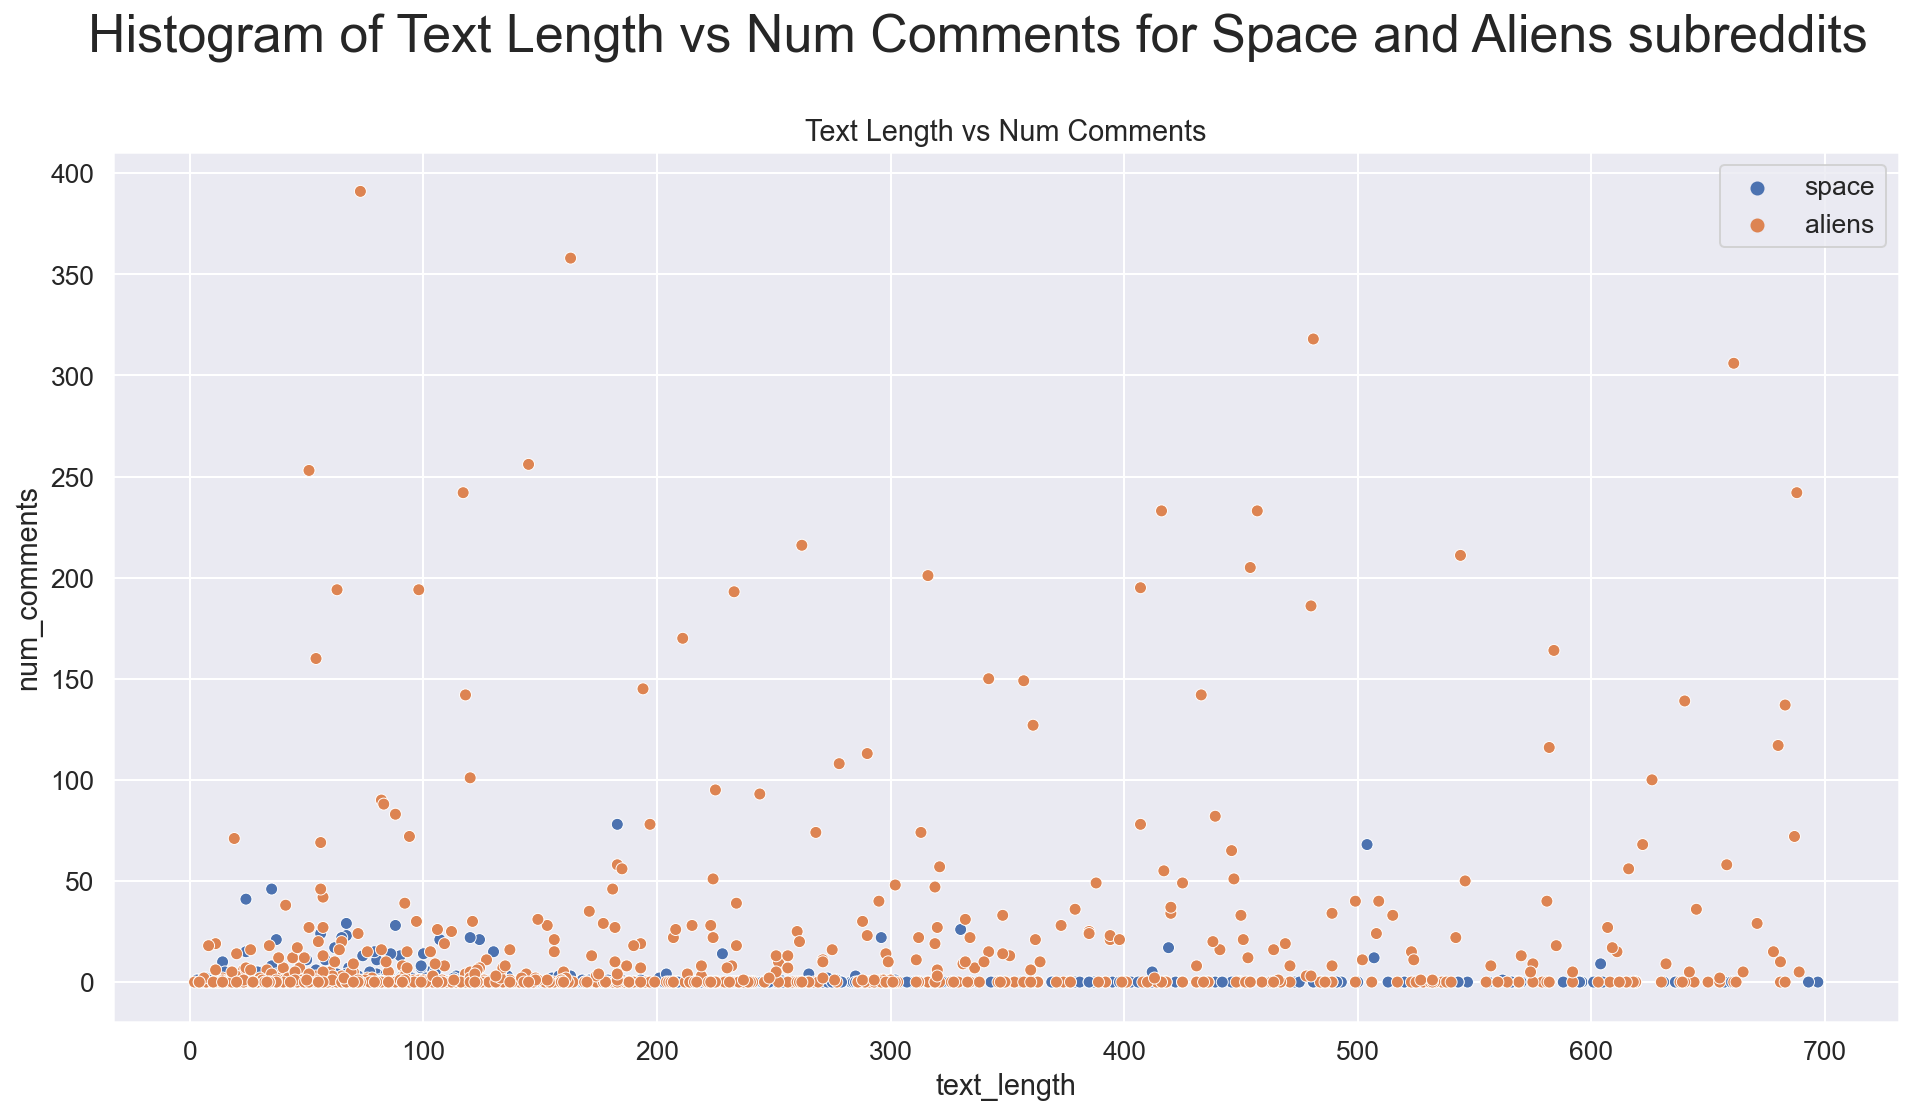

In [80]:
# Lets take a look at text length to num_commments
fig = plt.figure(figsize=(16,8))
plt.title('Text Length vs Num Comments')
sns.scatterplot(x='text_length',y='num_comments',data=df, hue='subreddit')
fig.suptitle('Histogram of Text Length vs Num Comments for Space and Aliens subreddits', fontsize=26, y=1)
fig.savefig('./images/histogram_text_length_num_comments_2_subreddits.png')
plt.legend();

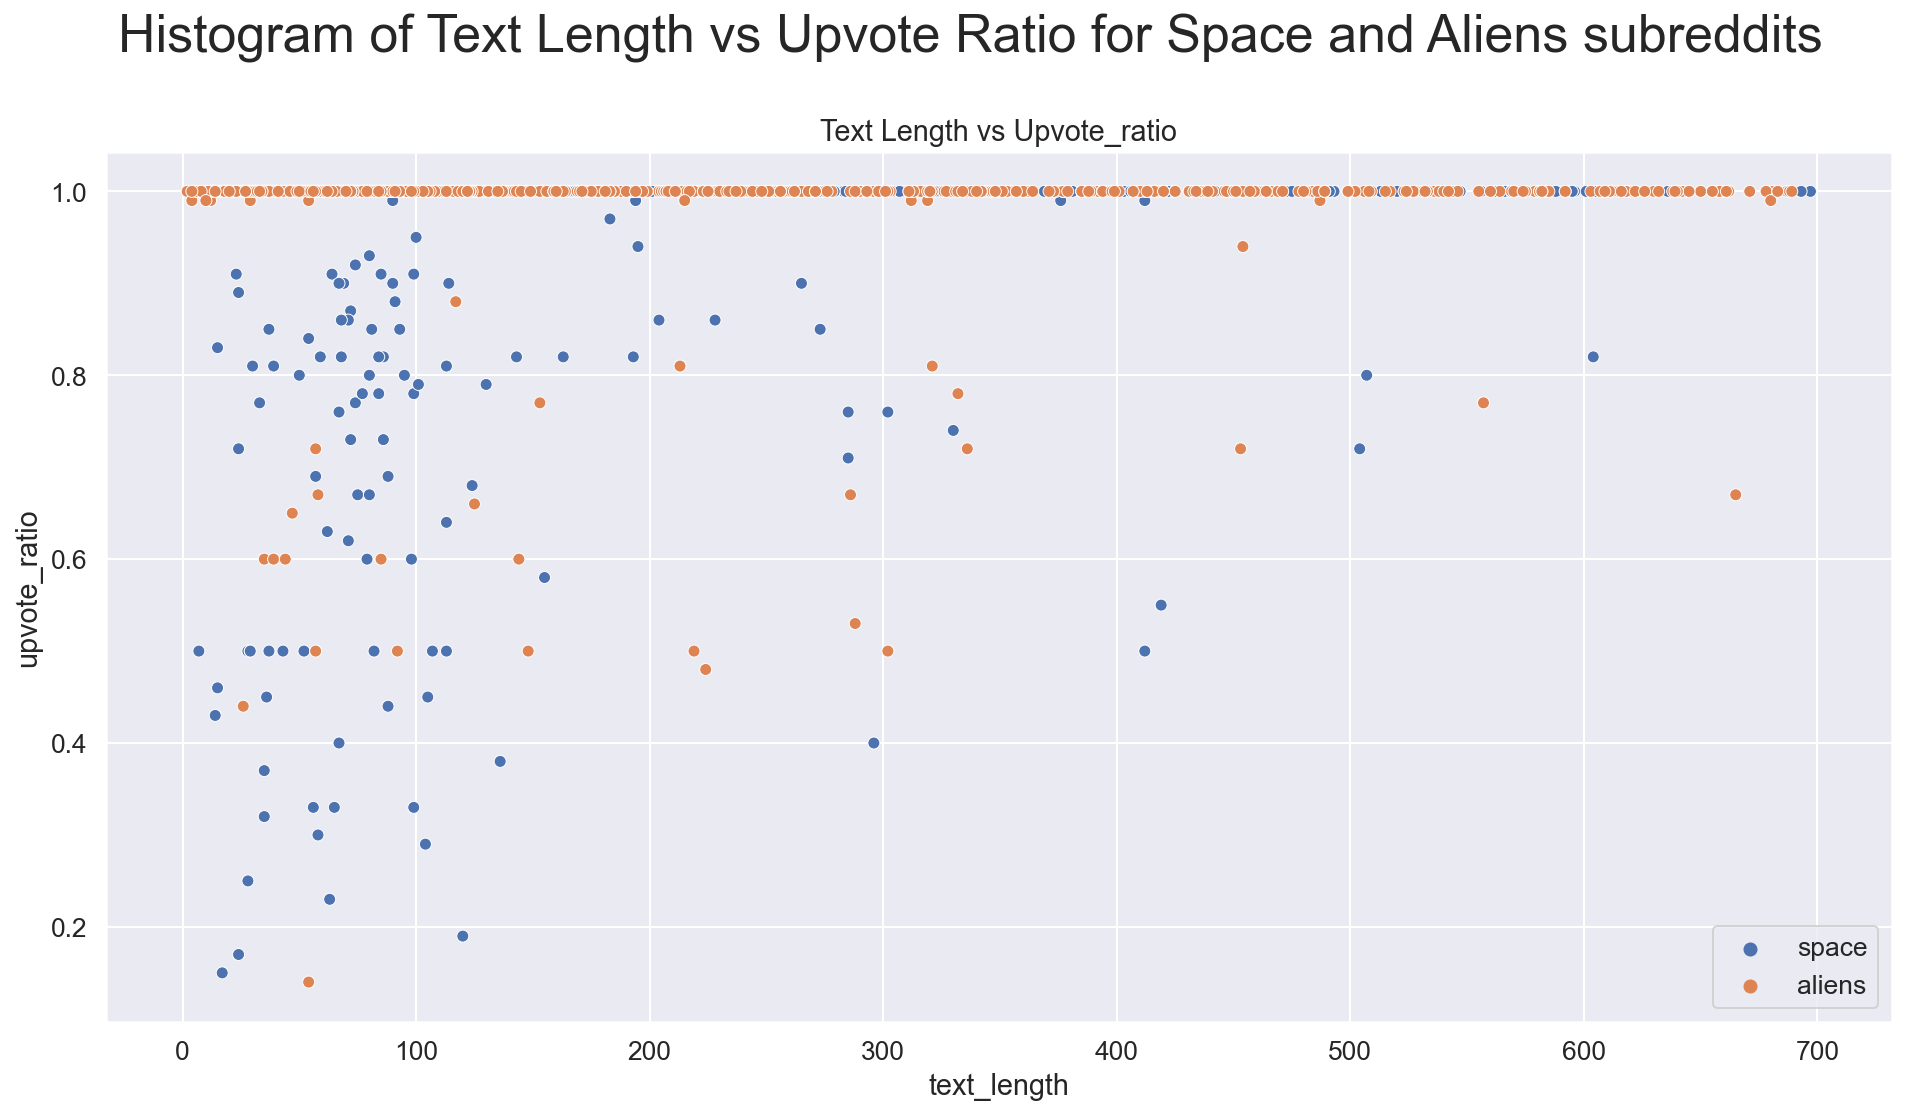

In [81]:
# Lets take a look at text length to upvote_ratio
fig = plt.figure(figsize=(16,8))
plt.title('Text Length vs Upvote_ratio')
sns.scatterplot(x='text_length',y='upvote_ratio',data=df, hue='subreddit')
fig.suptitle('Histogram of Text Length vs Upvote Ratio for Space and Aliens subreddits', fontsize=26, y=1)
fig.savefig('./images/histogram_text_length_upvote_ratio_2_subreddits.png')
plt.legend();

### __Observation: Correlation Score and Num Comments__

1) There seems to be moderate correlation between score and number of comments(0.54).

2) Once the viewers find it useful, it will add in more comments and hence increases the comments. With the num of comments, it is further supported by the likability of the post.

3) However, this is more obvious in the space subreddit and more spread out for aliens. Perhaps, the num comments in aliens are more targetted to the specific subject.

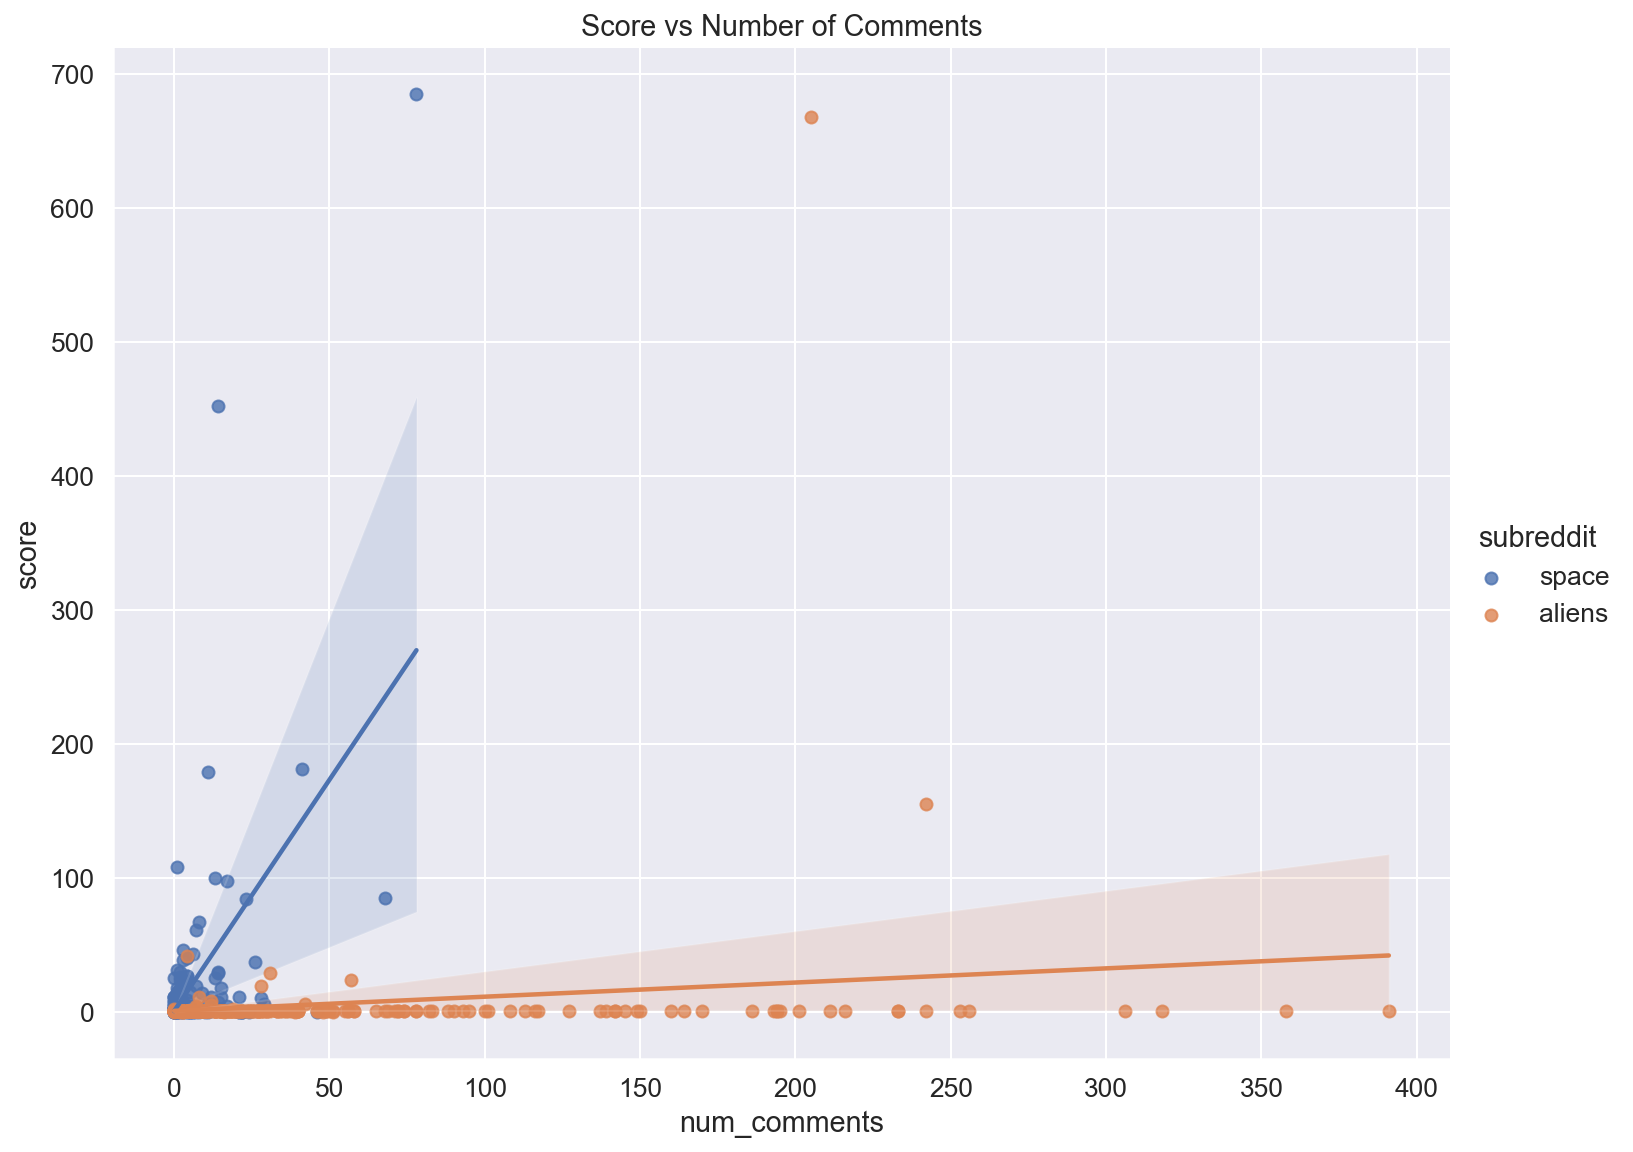

In [82]:
sns.lmplot(data=df, x='num_comments', y='score', hue='subreddit', height= 8, aspect=1.3)
ax = plt.gca()
ax.set_title("Score vs Number of Comments");

### __Observation: Correlation Upvote Ratio and Num Comments__

1) There seems to be little correlation between score and number of comments(0.045).

2) This is symmetrical to the score / num comments as upvote is identical to the score.

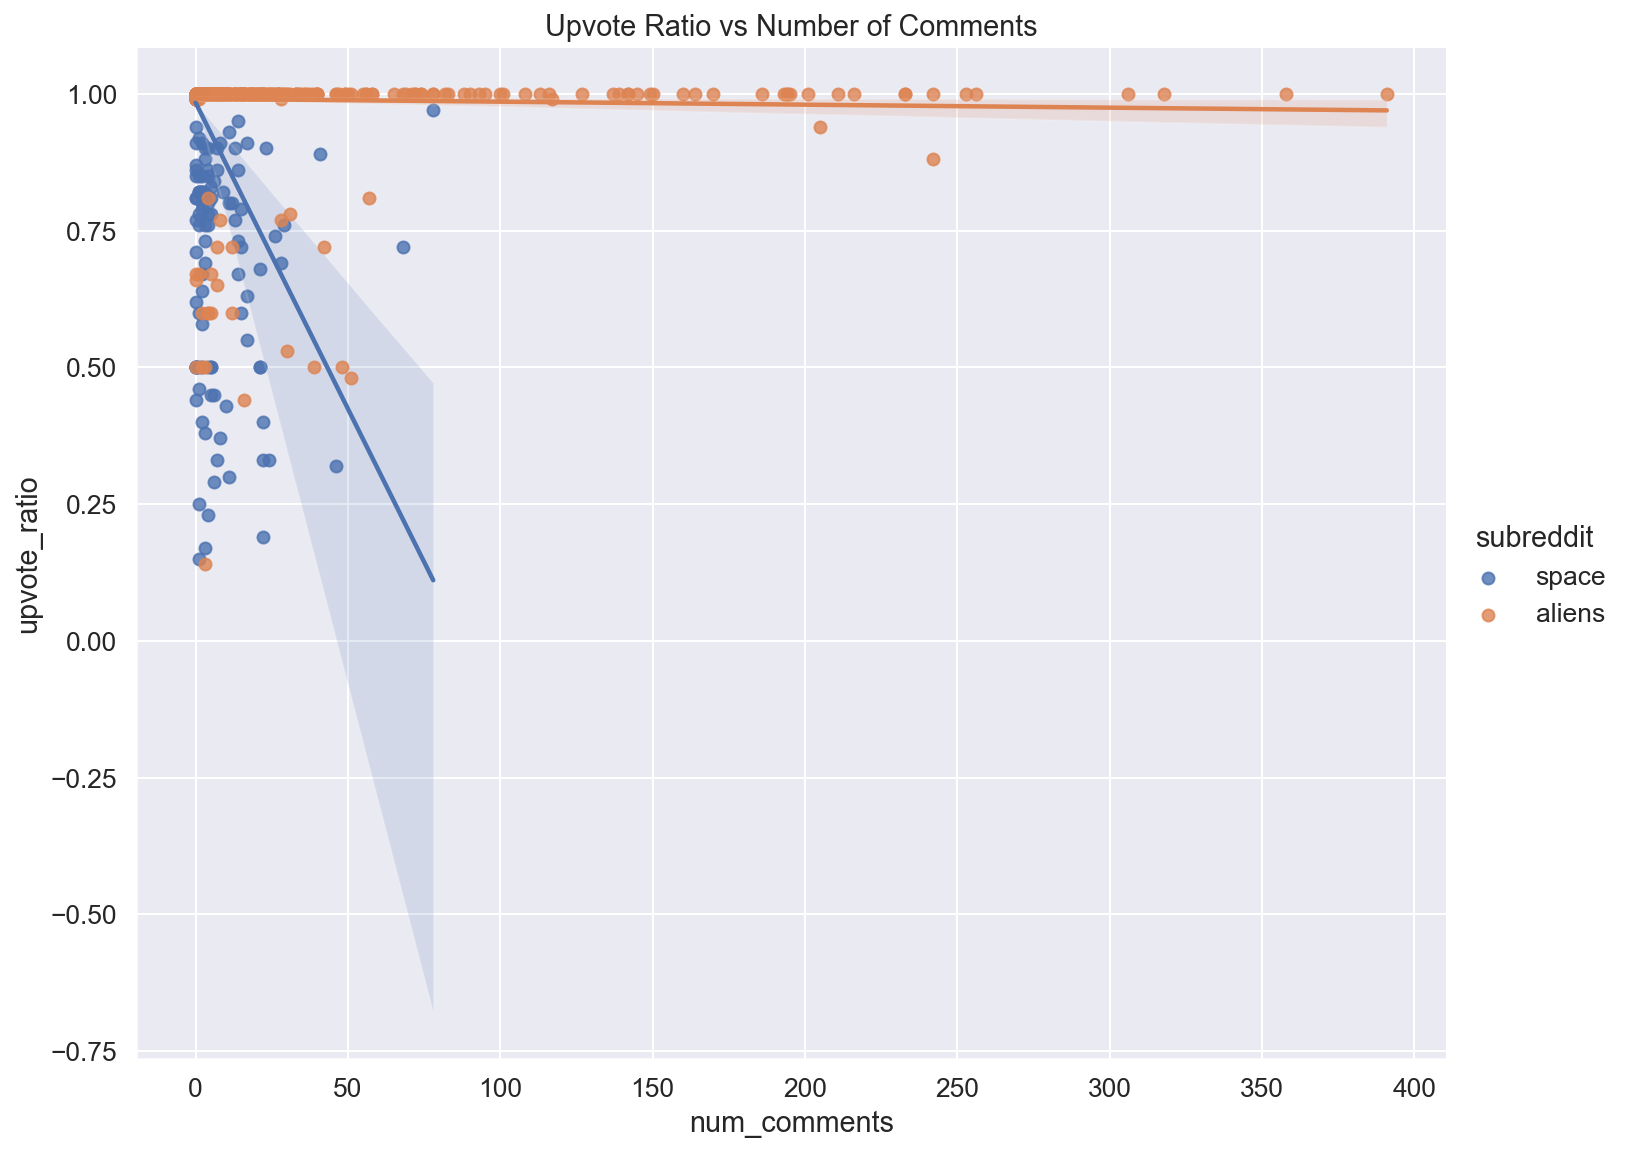

In [83]:
sns.lmplot(x='num_comments',y='upvote_ratio',data=df, hue='subreddit', height= 8, aspect=1.3)
ax = plt.gca()
ax.set_title("Upvote Ratio vs Number of Comments");

---
### __Observation:__

1) The popular words used are ufo, theory, mission, nasa, universe, human, earth, moon, star, etc

2) Based on the above EDA, there is enough information to answer the problem statement with the provided data.

3) During the inspection of data, summary statistics were generated, it shows there are relevant data to address the problem statement.

4) During the EDA stage, some interesting relationships between variables were identified. Also popular words were uncovered. Therefore, there is enough information at hand to address the problem statement.

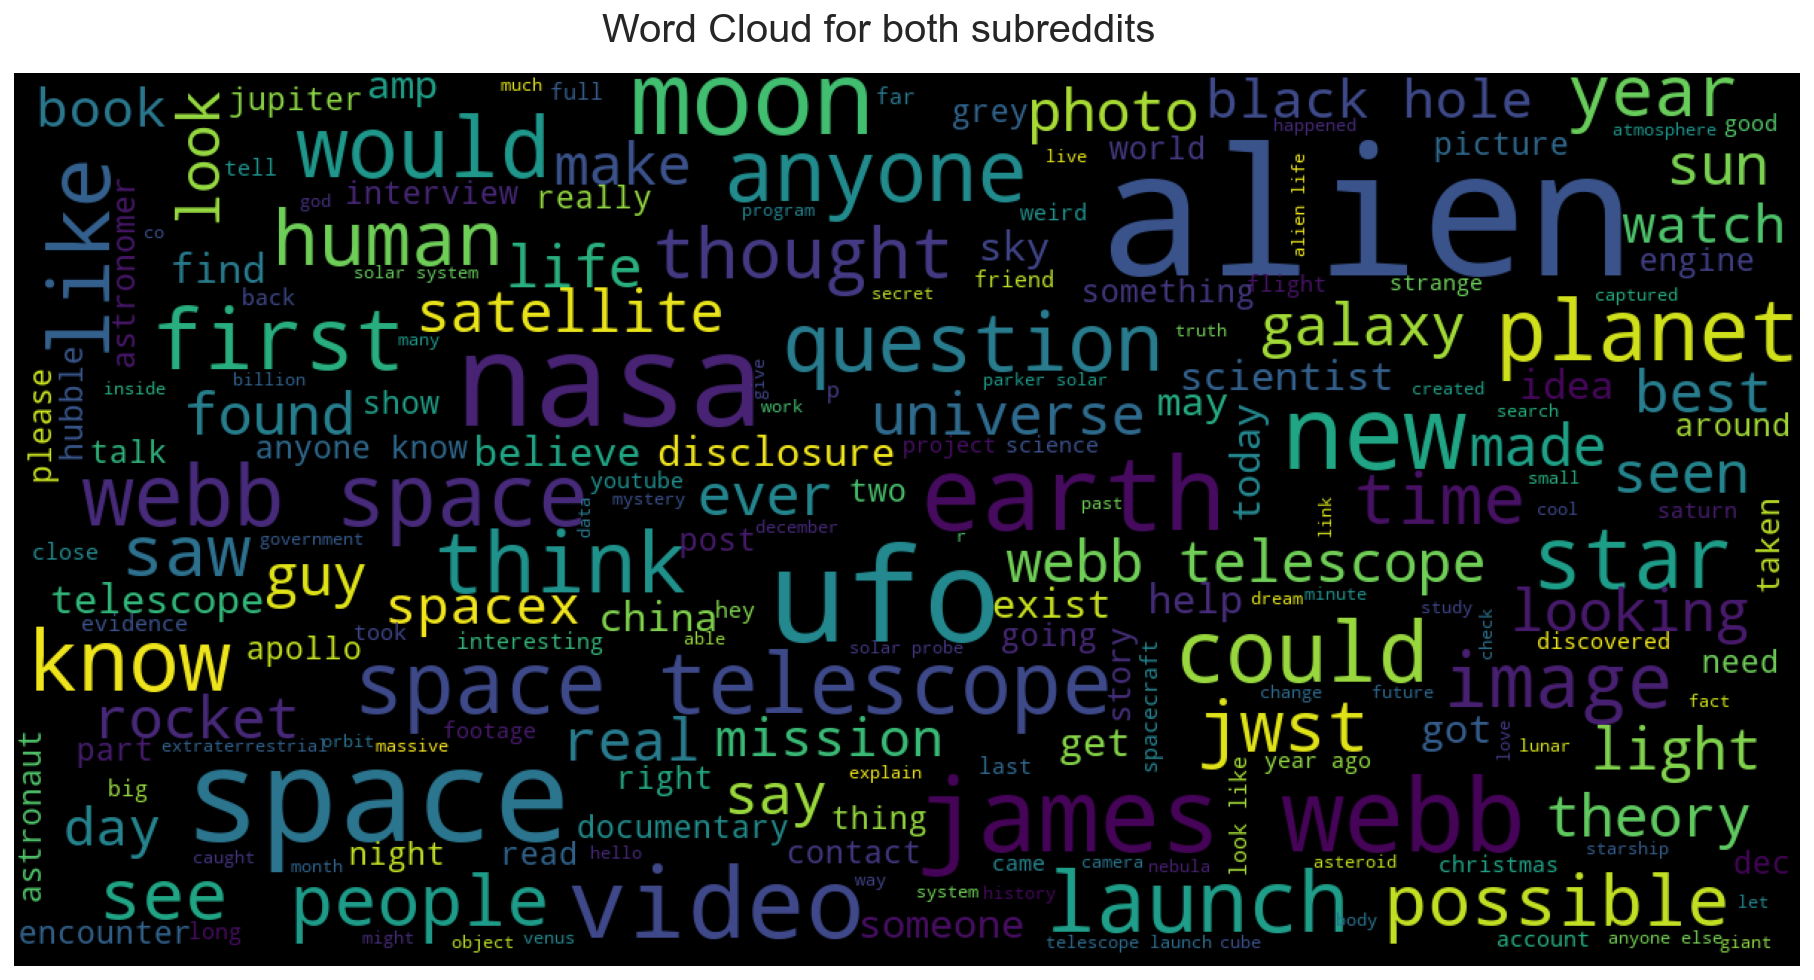

In [84]:
show_wordcloud(str(df.text),'Word Cloud for both subreddits','df')

In [85]:
df.head()

id subreddit                                              title  \
0  rmzn01     space               Does anyone know what this ive seen?   
1  rmzl73     space                 NASA Plans a Nuclear Plant on Moon   
2  rmz1sr     space               I think black holes might be pockets   
3  rmxpmy     space  Astronomers have produced the most comprehensi...   
4  rmxo1b     space  I considered this one of the sharpest moon ima...   

                                            selftext  score  upvote_ratio  \
0                                                         1           1.0   
1                                                         1           1.0   
2  Pockets specifically for holding things in "fo...      1           1.0   
3                                                         1           1.0   
4                                                         1           1.0   

   num_comments  word_length  \
0             1            7   
1             0            7   
2             0            7   
3             0           45   
4             0           22   

                                                text  text_length  is_aliens  
0                               anyone know ive seen         37.0          0  
1                       nasa plan nuclear plant moon         35.0          0  
2  think black hole might pocket pocket specifica...        219.0          0  
3  astronomer produced comprehensive image radio ...        283.0          0  
4  considered one sharpest moon image world final...        115.0          0

In [86]:
def plotter(column):
        fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
        ax = ax.ravel()
        g1 = sns.histplot(x=df[df['subreddit'] == 'space'][column], ax = ax[0], bins=20)
        mean_1 = df[df['subreddit'] == 'space'][column].mean()
        g1.set_title(f'r/Space (Mean: {round(mean_1)} {column})')
        ax[0].axvline(mean_1, ls='--', color='black')
        g2 = sns.histplot(x=df[df['subreddit'] == 'aliens'][column], ax = ax[1], bins=20, color='darkorange')
        mean_2 = df[df['subreddit'] == 'aliens'][column].mean()
        g2.set_title(f'r/Aliens (Mean: {round(mean_2)} {column})')
        ax[1].axvline(mean_2, ls='--', color='black')
        plt.suptitle(f'{column.capitalize()}', fontsize=20)
        plt.tight_layout()

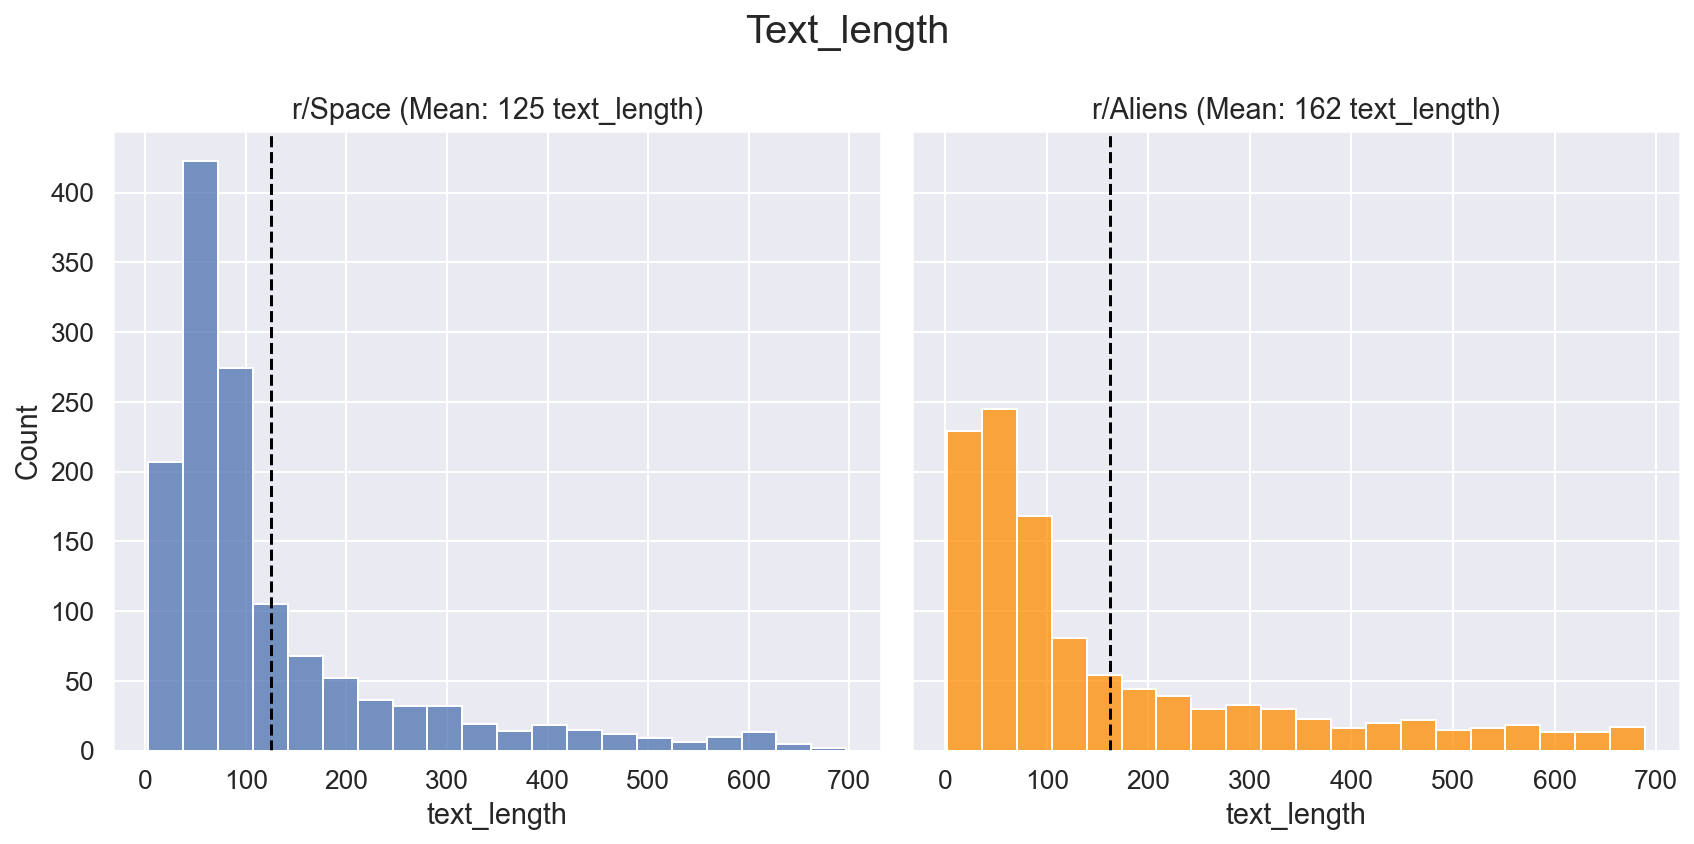

In [87]:
plotter('text_length')

In [88]:
df['text'].isna().sum()

0

In [89]:
df.head()

id subreddit                                              title  \
0  rmzn01     space               Does anyone know what this ive seen?   
1  rmzl73     space                 NASA Plans a Nuclear Plant on Moon   
2  rmz1sr     space               I think black holes might be pockets   
3  rmxpmy     space  Astronomers have produced the most comprehensi...   
4  rmxo1b     space  I considered this one of the sharpest moon ima...   

                                            selftext  score  upvote_ratio  \
0                                                         1           1.0   
1                                                         1           1.0   
2  Pockets specifically for holding things in "fo...      1           1.0   
3                                                         1           1.0   
4                                                         1           1.0   

   num_comments  word_length  \
0             1            7   
1             0            7   
2             0            7   
3             0           45   
4             0           22   

                                                text  text_length  is_aliens  
0                               anyone know ive seen         37.0          0  
1                       nasa plan nuclear plant moon         35.0          0  
2  think black hole might pocket pocket specifica...        219.0          0  
3  astronomer produced comprehensive image radio ...        283.0          0  
4  considered one sharpest moon image world final...        115.0          0

In [90]:
# Keep usable columns and drop columns that don't add meaning. Rearrange the columns into a more logical order.
df1 = df[['is_aliens', 'text', 'score', 'upvote_ratio', 'num_comments']]
df1.head()

is_aliens                                               text  score  \
0          0                               anyone know ive seen      1   
1          0                       nasa plan nuclear plant moon      1   
2          0  think black hole might pocket pocket specifica...      1   
3          0  astronomer produced comprehensive image radio ...      1   
4          0  considered one sharpest moon image world final...      1   

   upvote_ratio  num_comments  
0           1.0             1  
1           1.0             0  
2           1.0             0  
3           1.0             0  
4           1.0             0

In [91]:
# Save to master file
df1.to_csv('./data/dffinal.csv')

### __Analysis__

- Are steps taken during data cleaning and EDA framed appropriately?
- Does the student address whether or not they are likely to be able to answer their problem statement with the provided data given what they've discovered during EDA?


__With the above data cleaning steps and EDA, we have reviewed the correlation of the posting texts with other columns. This is to ensure the texts are framed correctly for the preprocessing and modeling.__

__Also, the combination of title and selftext have sufficient data through the word cloud and histogram, which provided good discovery to answer the problem statement.__

## Preprocessing & Modeling

### __Observation__

- Is text data successfully converted to a matrix representation?
- Are methods such as stop words, stemming, and lemmatization explored?

__Text data is succcessfully converted to matrix representation by tokenizing in the earlier section. It is to prepare for lemmatizaton. Lemmatization was chosen than stemming from the reason below. Stopwords was then used to eliminate words with no meaning.__

Side-note: Stemming just removes or stems the last few characters of a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.

__Next, we will explore CountVectorize and TF-IDF word statistics before including into the modeling for optimisation.__

In [92]:
df = pd.read_csv('./data/dffinal.csv')

---
__We will now use Count Vectorizer and Tfidf Vectorizer to explore the token counts in both subreddits. We will explore ngram (1,3) and ngram (2,2)__

In [93]:
df = df.drop(columns='Unnamed: 0')

In [94]:
df= df.dropna(subset=['text'], )

In [95]:
df['text'].isna().sum()

0

In [96]:
df.head()

is_aliens                                               text  score  \
0          0                               anyone know ive seen      1   
1          0                       nasa plan nuclear plant moon      1   
2          0  think black hole might pocket pocket specifica...      1   
3          0  astronomer produced comprehensive image radio ...      1   
4          0  considered one sharpest moon image world final...      1   

   upvote_ratio  num_comments  
0           1.0             1  
1           1.0             0  
2           1.0             0  
3           1.0             0  
4           1.0             0

### ngram(1,3)

In [97]:
# Instantiate CountVectorizer & TfidfVectorizer 
cvec = CountVectorizer(ngram_range=(1,3))
tvec = TfidfVectorizer(ngram_range=(1,3))

In [98]:
# Fit cvec & tvec to find most words in space
words_cvec_space = pd.DataFrame(cvec.fit_transform(df[df.is_aliens==0].text).todense(),
                       columns=cvec.get_feature_names())
words_cvec_counts_space = words_cvec_space.sum(axis=0)

words_tvec_space = pd.DataFrame(tvec.fit_transform(df[df.is_aliens==0].text).todense(),
                       columns=tvec.get_feature_names())
words_tvec_counts_space = words_tvec_space.sum(axis=0)

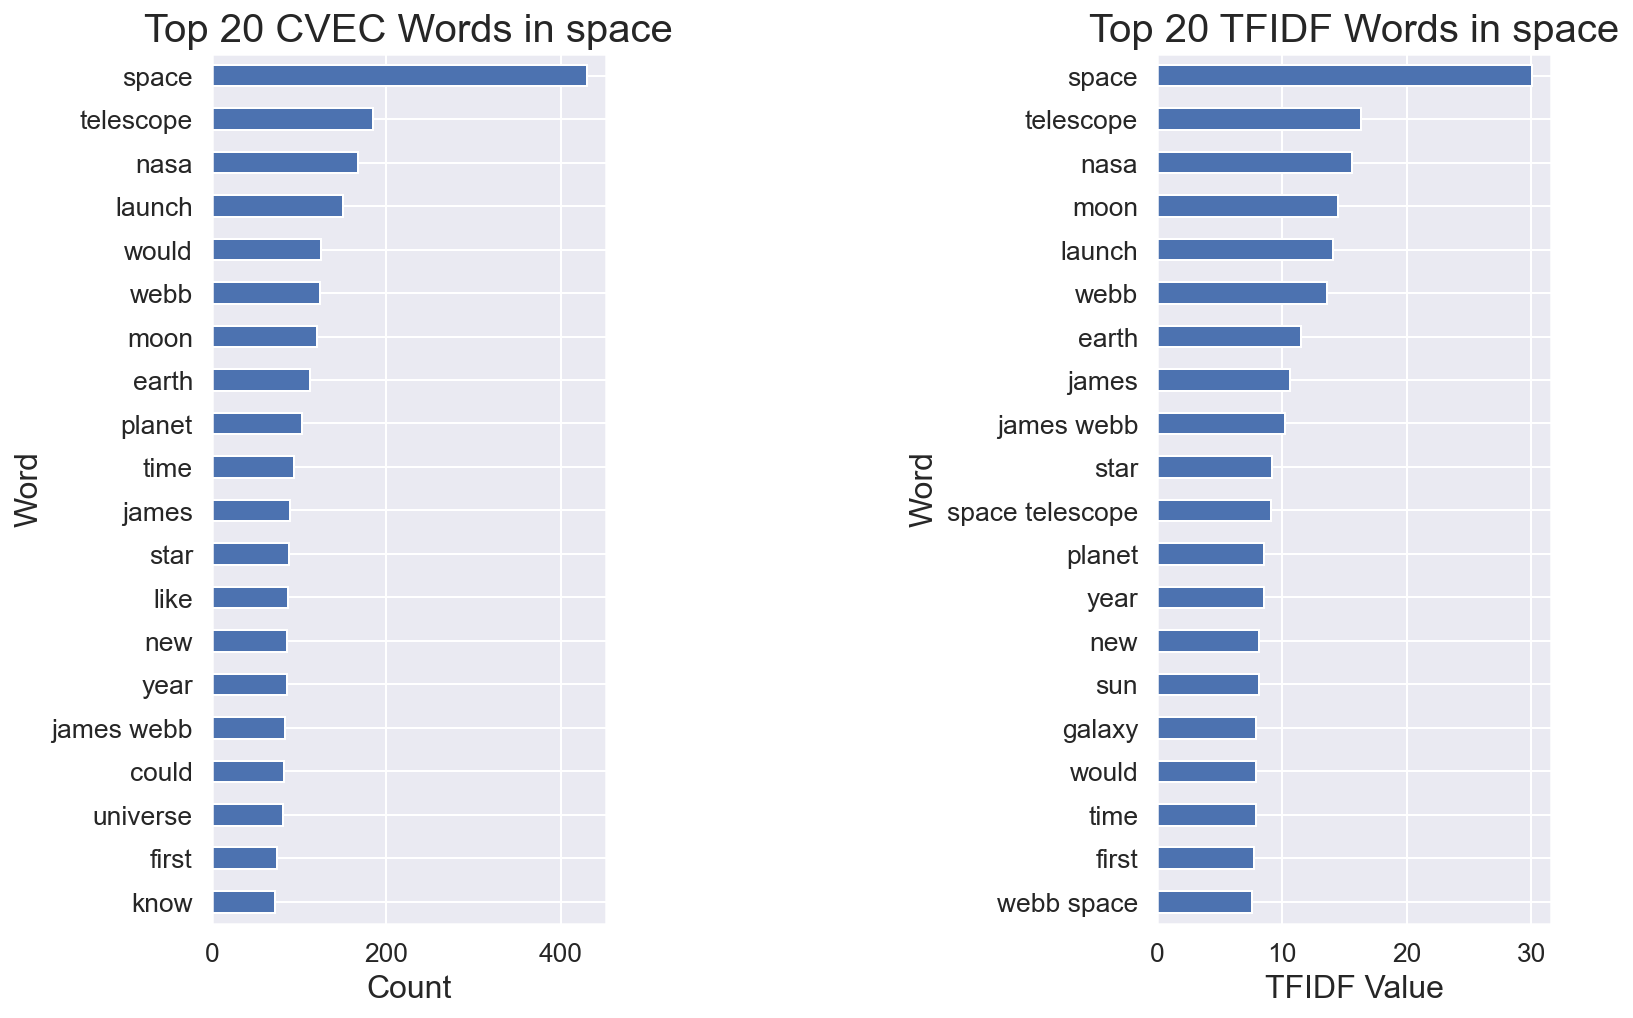

In [99]:
#Plotting bar charts on space
fig = plt.figure(figsize=(12,8), facecolor='white')

#Plotting bar chat for cvec
plt.subplot(1,3,1)
words_cvec_counts_space.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 CVEC Words in space', fontsize=20)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Word', fontsize=16)

#Plotting bar chart for tvec
plt.subplot(1,3,3)
words_tvec_counts_space.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in space', fontsize=20)
plt.xlabel('TFIDF Value', fontsize=16)
plt.ylabel('Word', fontsize=16);

fig.savefig('./images/cvec_tvec_space.png')
plt.show();

### __Observation__

Based on the two bar chart above, they show the top 20 words in space posts. Words such as telescope, nasa, launch and webb all appeared in both top 5 and frequently associate with space related matters. Webb is related to James Webb Space Telescope and hence it appeared in Top 5.

---

In [100]:
# Fit cvec & tvec to find most words in space
words_cvec_aliens = pd.DataFrame(cvec.fit_transform(df[df.is_aliens==1].text).todense(),
                       columns=cvec.get_feature_names())
words_cvec_counts_aliens = words_cvec_aliens.sum(axis=0)

words_tvec_aliens = pd.DataFrame(tvec.fit_transform(df[df.is_aliens==1].text).todense(),
                       columns=tvec.get_feature_names())
words_tvec_counts_aliens = words_tvec_aliens.sum(axis=0)

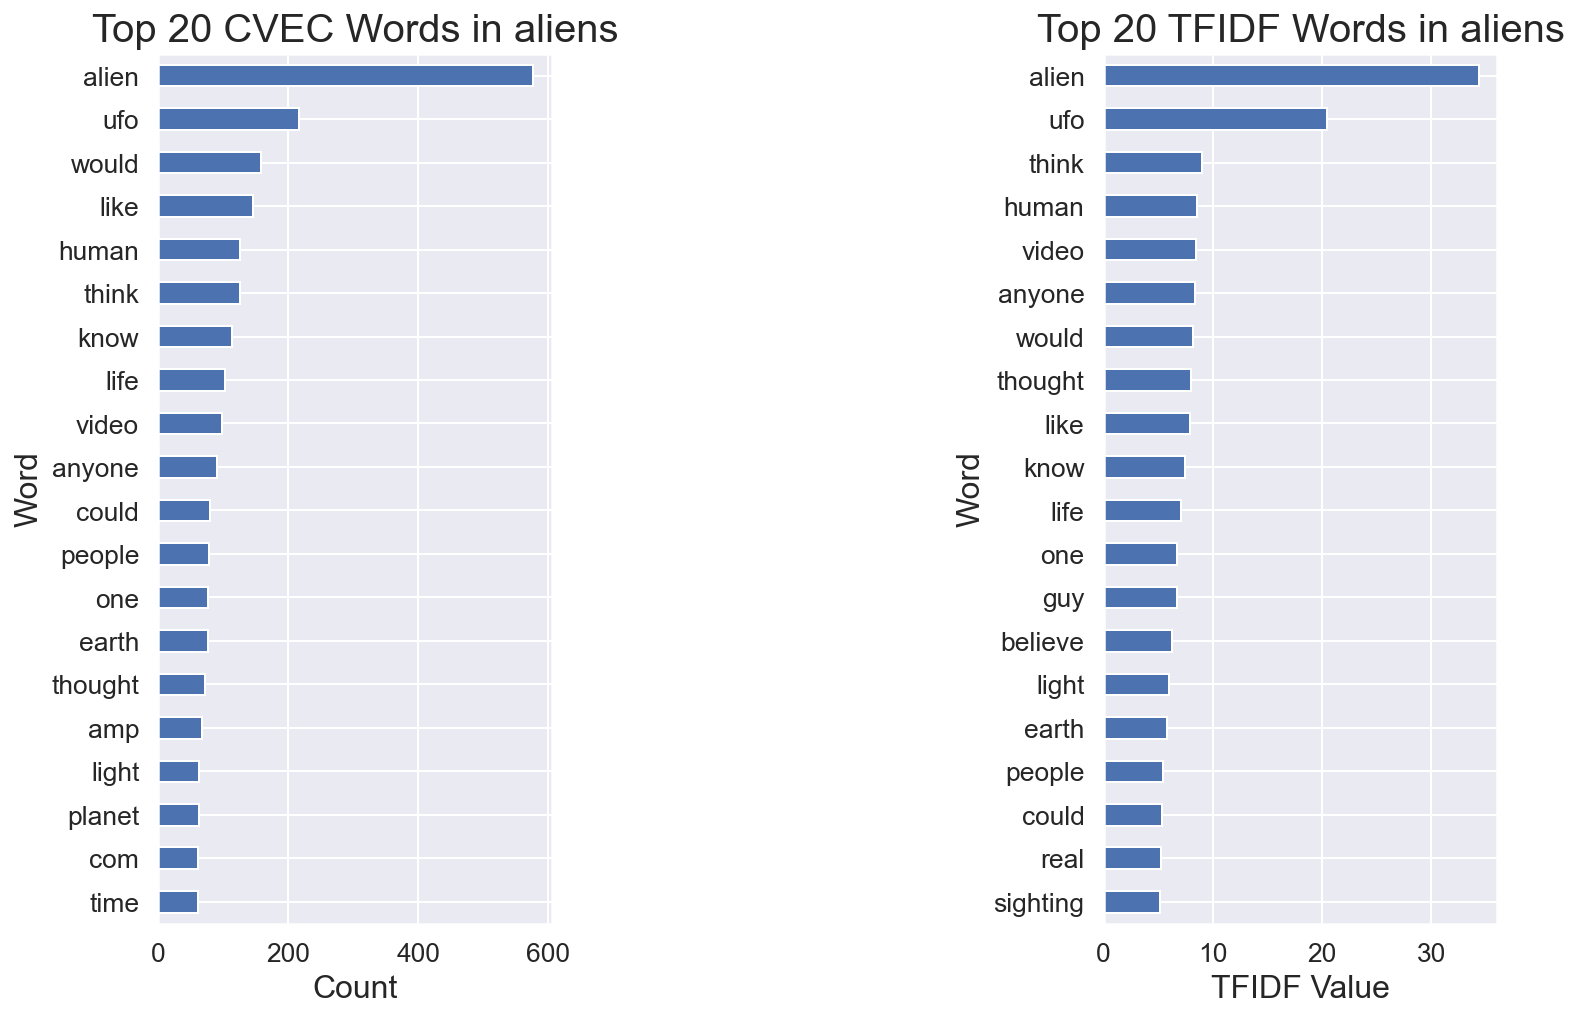

In [101]:
#Plotting bar charts on aliens
fig = plt.figure(figsize=(12,8), facecolor='white')

#Plotting bar chat for cvec
plt.subplot(1,3,1)
words_cvec_counts_aliens.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 CVEC Words in aliens', fontsize=20)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Word', fontsize=16)

#Plotting bar chart for tvec
plt.subplot(1,3,3)
words_tvec_counts_aliens.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in aliens', fontsize=20)
plt.xlabel('TFIDF Value', fontsize=16)
plt.ylabel('Word', fontsize=16);

fig.savefig('./images/cvec_tvec_aliens.png')
plt.show();

### __Observation__

Based on the two bar chart above, they show the top 20 words in aliens posts. Words such as ufo, think, human all appeared in both top 5 and frequently associate with aliens related matters. The word think would suggest that it is all in personal opinions without factual evidence as what aliens appeared to the world.

---

__Exploring the common words in cvec and tvec in ngram(1,3)__

In [102]:
# Set up variables to contain top 5 most used words in space and aliens for cvec
space_top_5_cvec = words_cvec_counts_space.sort_values(ascending=False).head(5)
aliens_top_5_cvec = words_cvec_counts_aliens.sort_values(ascending=False).head(5)

In [103]:
# Create list of unique words in top five
space_5_set_cvec = set(space_top_5_cvec.index)
aliens_5_set_cvec = set(aliens_top_5_cvec.index)

# Return common words
common_unigrams_cvec = space_5_set_cvec.intersection(aliens_5_set_cvec)
common_unigrams_cvec

{'would'}

In [104]:
print(f'space: {space_5_set_cvec}')
print(f'aliens: {aliens_5_set_cvec}')

space: {'launch', 'nasa', 'would', 'space', 'telescope'}
aliens: {'ufo', 'human', 'like', 'would', 'alien'}


In [105]:
# Set up variables to contain top 5 most used words in space and aliens for tvec
space_top_5_tvec = words_tvec_counts_space.sort_values(ascending=False).head(5)
aliens_top_5_tvec = words_tvec_counts_aliens.sort_values(ascending=False).head(5)

In [106]:
# Create list of unique words in top five
space_5_set_tvec = set(space_top_5_tvec.index)
aliens_5_set_tvec = set(aliens_top_5_tvec.index)

# Return common words
common_unigrams_tvec = space_5_set_tvec.intersection(aliens_5_set_tvec)
common_unigrams_tvec

set()

In [107]:
print(f'space: {space_5_set_tvec}')
print(f'aliens: {aliens_5_set_tvec}')

space: {'launch', 'nasa', 'moon', 'space', 'telescope'}
aliens: {'ufo', 'think', 'human', 'video', 'alien'}


### ngram(2,2)

In [108]:
# Instantiate CountVectorizer & TfidfVectorizer 
cvec = CountVectorizer(ngram_range=(2,2))
tvec = TfidfVectorizer(ngram_range=(2,2))

In [109]:
# Fit cvec & tvec to find most words in space
words_cvec_space = pd.DataFrame(cvec.fit_transform(df[df.is_aliens==0].text).todense(),
                       columns=cvec.get_feature_names())
words_cvec_counts_space = words_cvec_space.sum(axis=0)

words_tvec_space = pd.DataFrame(tvec.fit_transform(df[df.is_aliens==0].text).todense(),
                       columns=tvec.get_feature_names())
words_tvec_counts_space = words_tvec_space.sum(axis=0)

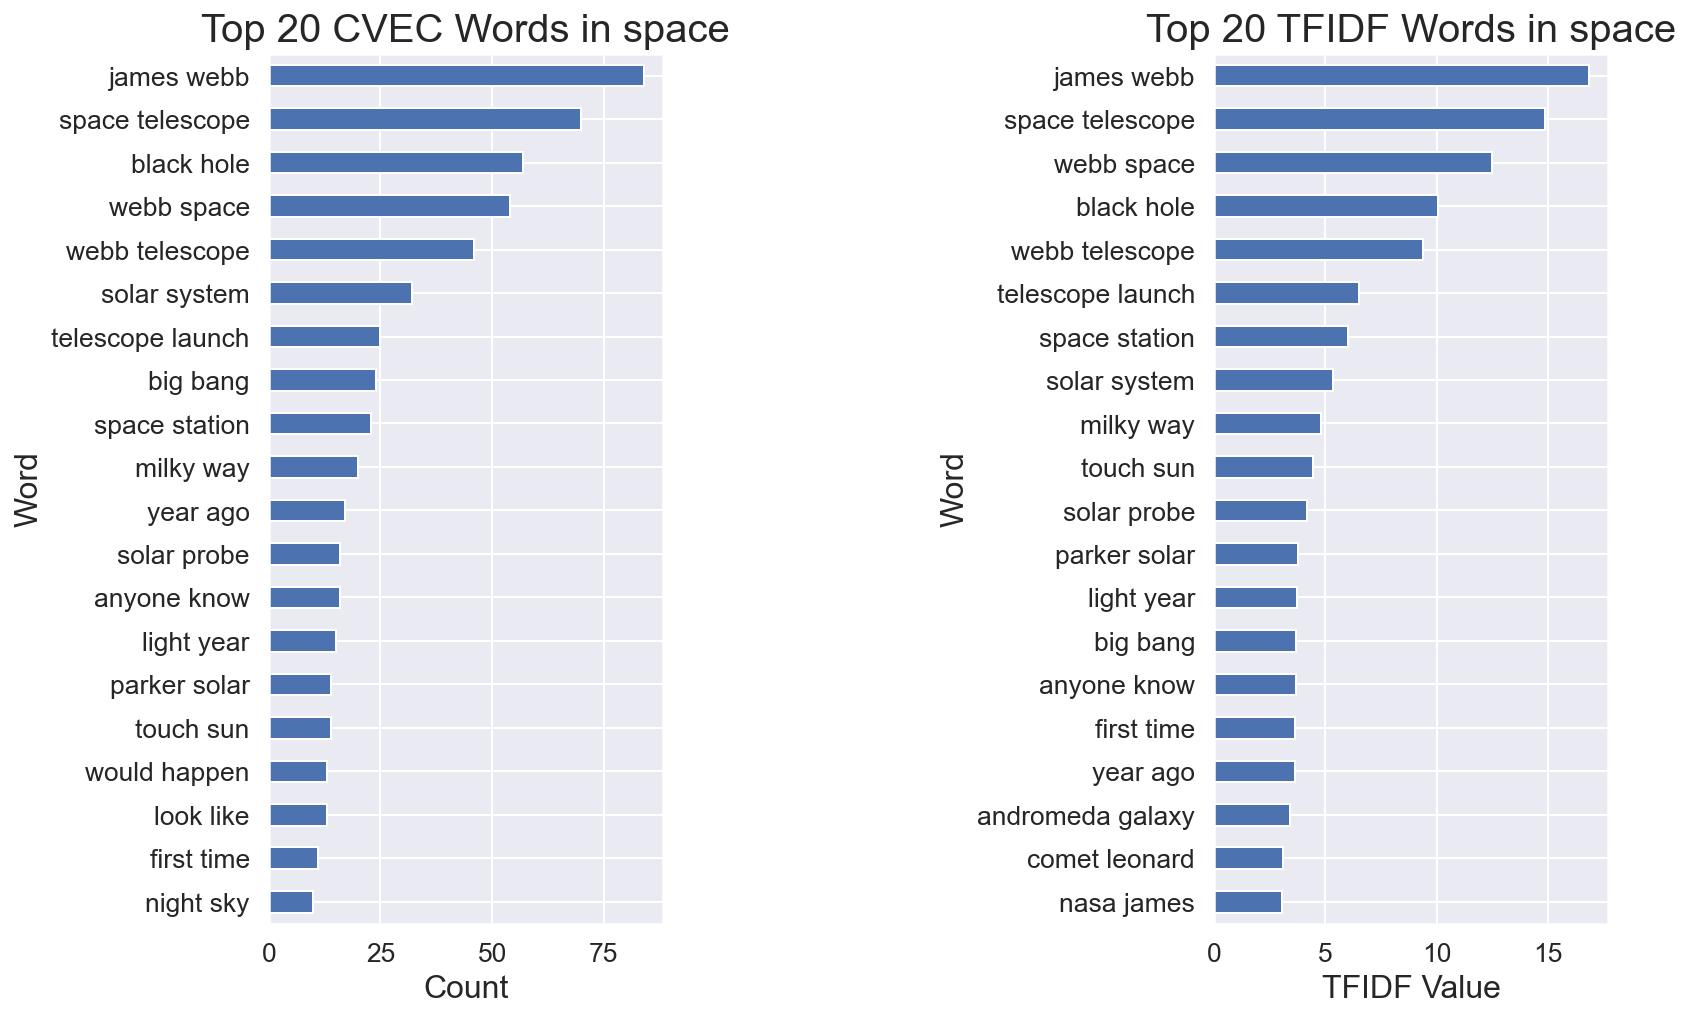

In [110]:
#Plotting bar charts on space
fig = plt.figure(figsize=(12,8), facecolor='white')

#Plotting bar chat for cvec
plt.subplot(1,3,1)
words_cvec_counts_space.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 CVEC Words in space', fontsize=20)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Word', fontsize=16)

#Plotting bar chart for tvec
plt.subplot(1,3,3)
words_tvec_counts_space.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in space', fontsize=20)
plt.xlabel('TFIDF Value', fontsize=16)
plt.ylabel('Word', fontsize=16);

fig.savefig('./images/cvec_tvec_space2.png')
plt.show();

### __Observation__

Based on the two bar chart above, they show the top 20 words in space posts. The top 5 words are the same and frequently associate with space related matters. 

---

In [111]:
# Fit cvec & tvec to find most words in aliens
words_cvec_aliens = pd.DataFrame(cvec.fit_transform(df[df.is_aliens==1].text).todense(),
                       columns=cvec.get_feature_names())
words_cvec_counts_aliens = words_cvec_aliens.sum(axis=0)

words_tvec_aliens = pd.DataFrame(tvec.fit_transform(df[df.is_aliens==1].text).todense(),
                       columns=tvec.get_feature_names())
words_tvec_counts_aliens = words_tvec_aliens.sum(axis=0)

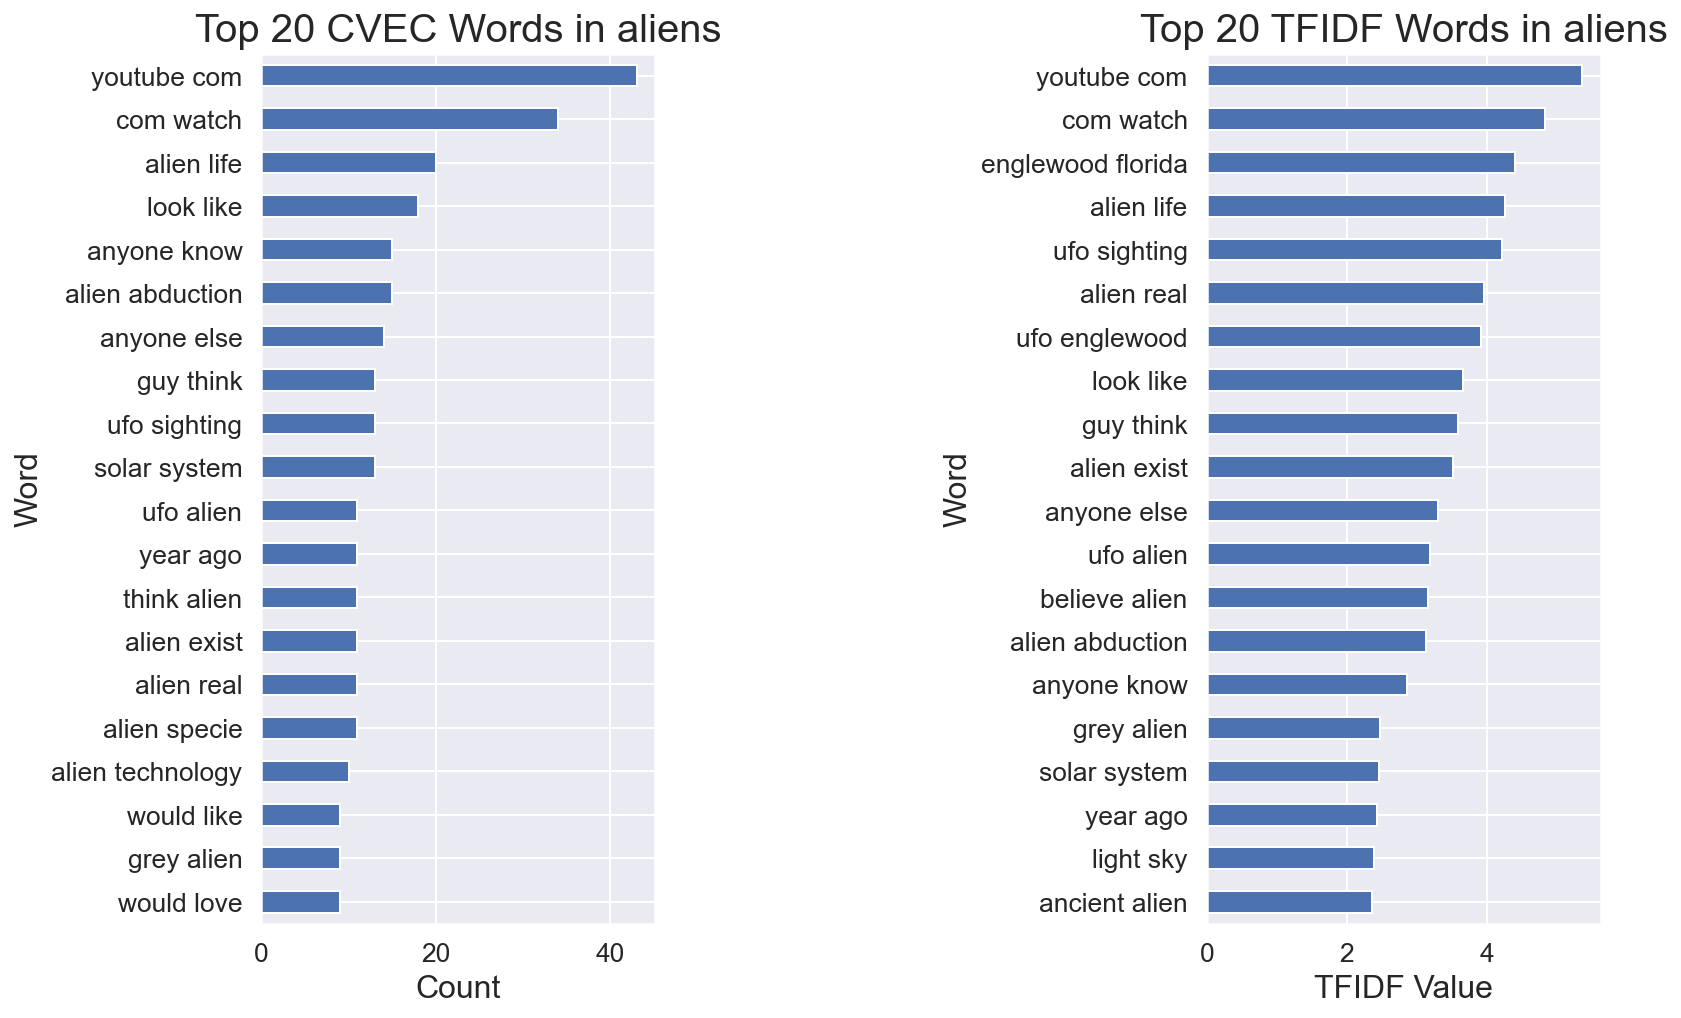

In [112]:
#Plotting bar charts on aliens
fig = plt.figure(figsize=(12,8), facecolor='white')

#Plotting bar chat for cvec
plt.subplot(1,3,1)
words_cvec_counts_aliens.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 CVEC Words in aliens', fontsize=20)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Word', fontsize=16)

#Plotting bar chart for tvec
plt.subplot(1,3,3)
words_tvec_counts_aliens.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in aliens', fontsize=20)
plt.xlabel('TFIDF Value', fontsize=16)
plt.ylabel('Word', fontsize=16);

fig.savefig('./images/cvec_tvec_aliens2.png')
plt.show();

### __Observation__

Based on the two bar chart above, they show the top 20 words in aliens posts. Words such as youtube com and com watch all appeared in both top 5 and frequently associate with aliens related matters. 

---

__Exploring the common words in cvec and tvec in ngram(2,2)__

In [113]:
# Set up variables to contain top 5 most used words in space and aliens for cvec
space_top_5_cvec = words_cvec_counts_space.sort_values(ascending=False).head(5)
aliens_top_5_cvec = words_cvec_counts_aliens.sort_values(ascending=False).head(5)

In [114]:
# Create list of unique words in top five
space_5_set_cvec = set(space_top_5_cvec.index)
aliens_5_set_cvec = set(aliens_top_5_cvec.index)

# Return common words
common_unigrams_cvec = space_5_set_cvec.intersection(aliens_5_set_cvec)
common_unigrams_cvec

set()

In [115]:
print(f'space: {space_5_set_cvec}')
print(f'aliens: {aliens_5_set_cvec}')

space: {'black hole', 'webb space', 'webb telescope', 'space telescope', 'james webb'}
aliens: {'youtube com', 'anyone know', 'look like', 'alien life', 'com watch'}


In [116]:
# Set up variables to contain top 5 most used words in space and aliens for tvec
space_top_5_tvec = words_tvec_counts_space.sort_values(ascending=False).head(5)
aliens_top_5_tvec = words_tvec_counts_aliens.sort_values(ascending=False).head(5)

In [117]:
# Create list of unique words in top five
space_5_set_tvec = set(space_top_5_tvec.index)
aliens_5_set_tvec = set(aliens_top_5_tvec.index)

# Return common words
common_unigrams_tvec = space_5_set_tvec.intersection(aliens_5_set_tvec)
common_unigrams_tvec

set()

In [118]:
print(f'space: {space_5_set_tvec}')
print(f'aliens: {aliens_5_set_tvec}')

space: {'black hole', 'webb space', 'webb telescope', 'space telescope', 'james webb'}
aliens: {'youtube com', 'alien life', 'ufo sighting', 'com watch', 'englewood florida'}


In [119]:
# Save to master file
df.to_csv('./data/dfmaster.csv', index=False)